In [21]:
import pandas as pd
from pathlib import Path

# -----------------------------
# 0) Load
# -----------------------------
in_path = Path(r"D:\papers_alberto\cau_predictom\features_data\all_ad_syndrome_spect-ent_wide_ROI_nonan.csv")
df = pd.read_csv(in_path)

# -----------------------------
# 1) Define columns
# -----------------------------
id_col   = "participant_id"
roi_col  = "ROI"
target   = "ad_syndrome"

# keep these as subject-level metadata (must be constant within subject across ROIs)
meta_cols = [id_col, target, "center", "age"]

# features are everything from "permutation" onwards (as you requested)
start_feat = "permutation"
feat_cols = df.columns[df.columns.get_loc(start_feat):].tolist()

# -----------------------------
# 2) Clean ROI names + assert 3 ROIs per subject
# -----------------------------
roi_map = {"anterior": "anterior", "central": "center", "posterior": "posterior"}
df[roi_col] = df[roi_col].map(roi_map)

assert df[roi_col].isna().sum() == 0, "Unexpected ROI labels found."

n_rois_per_subj = df.groupby(id_col)[roi_col].nunique()
assert (n_rois_per_subj == 3).all(), f"Not all subjects have 3 ROIs. Counts:\n{n_rois_per_subj.value_counts()}"

# confirm subject-level metadata is unique per subject
meta_nunique = df.groupby(id_col)[meta_cols[1:]].nunique().max()
assert (meta_nunique <= 1).all(), f"Metadata varies within subject:\n{meta_nunique}"

# -----------------------------
# 3) Pivot to wide: one row per subject, feature suffix = ROI
# -----------------------------
wide_feats = (
    df.pivot(index=id_col, columns=roi_col, values=feat_cols)
)

# Flatten MultiIndex columns -> "feature_roi"
wide_feats.columns = [f"{feat}_{roi}" for feat, roi in wide_feats.columns]
wide_feats = wide_feats.reset_index()

# add subject-level metadata back
meta = df[meta_cols].drop_duplicates(subset=[id_col])
df_wide = meta.merge(wide_feats, on=id_col, how="inner")

# -----------------------------
# 4) Quick sanity checks
# -----------------------------
print("Input shape (long):", df.shape)
print("Output shape (wide):", df_wide.shape)
print("N subjects:", df_wide[id_col].nunique())
print("Target classes:", sorted(df_wide[target].unique()))

# show a peek
df_wide.head()
df_wide.to_csv("D:/papers_alberto/cau_predictom/features_data/all_ad_syndrome_spect-ent_wide_ROI_nonan_test.csv", index=False)


Input shape (long): (2847, 33)
Output shape (wide): (949, 88)
N subjects: 949
Target classes: ['dementia', 'hc', 'mci', 'smc']


In [24]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeCV
from sklearn.metrics import log_loss

from hidimstat import PFICV, CFICV, LOCOCV

# -----------------------------
# Inputs (assumes df_wide exists)
# -----------------------------
id_col = "participant_id"
target = "ad_syndrome"

X_df = df_wide.drop(columns=[id_col, "center", target])
y = df_wide[target].astype(str).to_numpy()

X = X_df.to_numpy()
feature_names = X_df.columns.to_list()

# ✅ FIX: features_groups must map to integer column indices
features_groups = {fn: [i] for i, fn in enumerate(feature_names)}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

clf = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(
            solver="liblinear",
            class_weight="balanced",
            max_iter=5000,
            random_state=0,
        )),
    ]
)

def binary_log_loss(y_true, y_proba):
    return log_loss(y_true, y_proba, labels=[0, 1])

def run_vim_ovr(
    X, y, classes,
    cv,
    clf,
    features_groups,
    n_permutations=50,
    n_jobs=-1,
    random_state=0,
):
    out_rows = []

    for cls in classes:
        y_bin = (y == cls).astype(int)

        pfi_cv = PFICV(
            estimators=clf,
            cv=cv,
            statistical_test="nb-ttest",
            method="predict_proba",
            loss=binary_log_loss,
            n_permutations=n_permutations,
            features_groups=features_groups,
            random_state=random_state,
            n_jobs=n_jobs,
        )
        pfi_cv.fit_importance(X, y_bin)

        cfi_cv = CFICV(
            estimators=clf,
            cv=cv,
            statistical_test="nb-ttest",
            method="predict_proba",
            loss=binary_log_loss,
            n_permutations=n_permutations,
            imputation_model_continuous=RidgeCV(alphas=np.logspace(-3, 3, 10)),
            imputation_model_categorical=LogisticRegressionCV(
                Cs=np.logspace(-3, 3, 10),
                cv=3,
                max_iter=2000,
                class_weight="balanced",
                solver="liblinear",
            ),
            # safest for your data (EEG features): treat as continuous
            feature_types="continuous",
            features_groups=features_groups,
            random_state=random_state,
            n_jobs=n_jobs,
        )
        cfi_cv.fit_importance(X, y_bin)

        loco_cv = LOCOCV(
            estimators=clf,
            cv=cv,
            statistical_test="nb-ttest",
            method="predict_proba",
            loss=binary_log_loss,
            features_groups=features_groups,
            n_jobs=n_jobs,
        )
        loco_cv.fit_importance(X, y_bin)

        # ---- collect ----
        for vim_obj, method_name in [(pfi_cv, "PFI"), (cfi_cv, "CFI"), (loco_cv, "LOCO")]:
            importances = np.asarray(vim_obj.importances_)  # (n_groups, n_folds)
            pvals = np.asarray(vim_obj.pvalues_)            # (n_groups,)

            df_one = pd.DataFrame({
                "class_pos": cls,
                "method": method_name,
                "feature": list(features_groups.keys()),
                "importance_mean": importances.mean(axis=1),
                "importance_sd": importances.std(axis=1, ddof=1),
                "pval": pvals,
            })
            out_rows.append(df_one)

    return pd.concat(out_rows, ignore_index=True)

classes = sorted(np.unique(y))
res_df = run_vim_ovr(
    X=X,
    y=y,
    classes=classes,
    cv=cv,
    clf=clf,
    features_groups=features_groups,
    n_permutations=50,
    n_jobs=-1,
    random_state=0,
)

top_df = (
    res_df.sort_values(["class_pos", "method", "pval", "importance_mean"],
                       ascending=[True, True, True, False])
          .groupby(["class_pos", "method"], as_index=False)
          .head(20)
)

print("res_df:", res_df.shape, "| classes:", classes)
display(top_df)


Computing importance scores over folds: 100%|██████████| 5/5 [00:00<00:00, 2484.78it/s]


res_df: (1020, 6) | classes: ['dementia', 'hc', 'mci', 'smc']


,class_pos,method,feature,importance_mean,importance_sd,pval
85,dementia,CFI,age,0.064426,0.008972,0.000216
152,dementia,CFI,beta_bw_anterior,0.016308,0.006668,0.010926
101,dementia,CFI,hjorth_mobility_anterior,0.000587,0.000312,0.024197
116,dementia,CFI,unc_delta_anterior,0.000466,0.000306,0.042755
128,dementia,CFI,unc_beta_anterior,0.000518,0.000401,0.063472
...,...,...,...,...,...,...
822,smc,PFI,dom_freq_posterior,0.031792,0.021141,0.044224
793,smc,PFI,petrosian_fd_anterior,0.006320,0.004398,0.049424
816,smc,PFI,fp_alphalow_posterior,0.012425,0.008690,0.050019
805,smc,PFI,unc_alphahigh_anterior,0.074898,0.052536,0.050374


Significant rows: 98 / 1020 using p<0.05


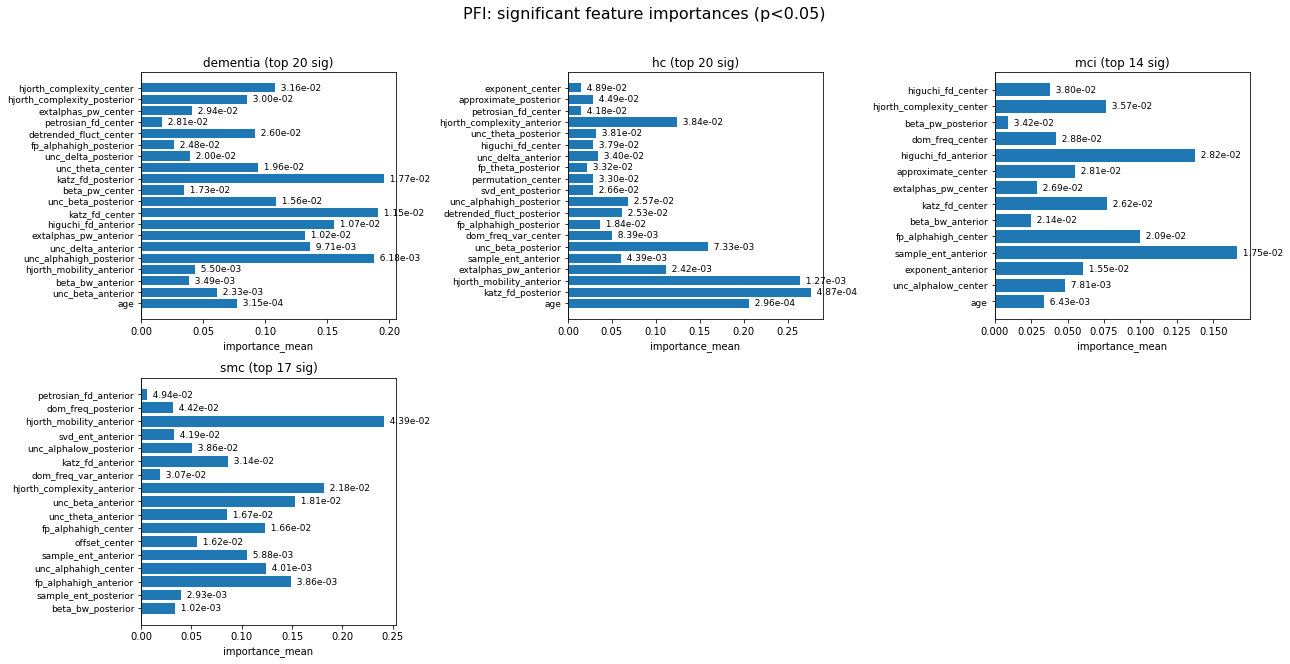

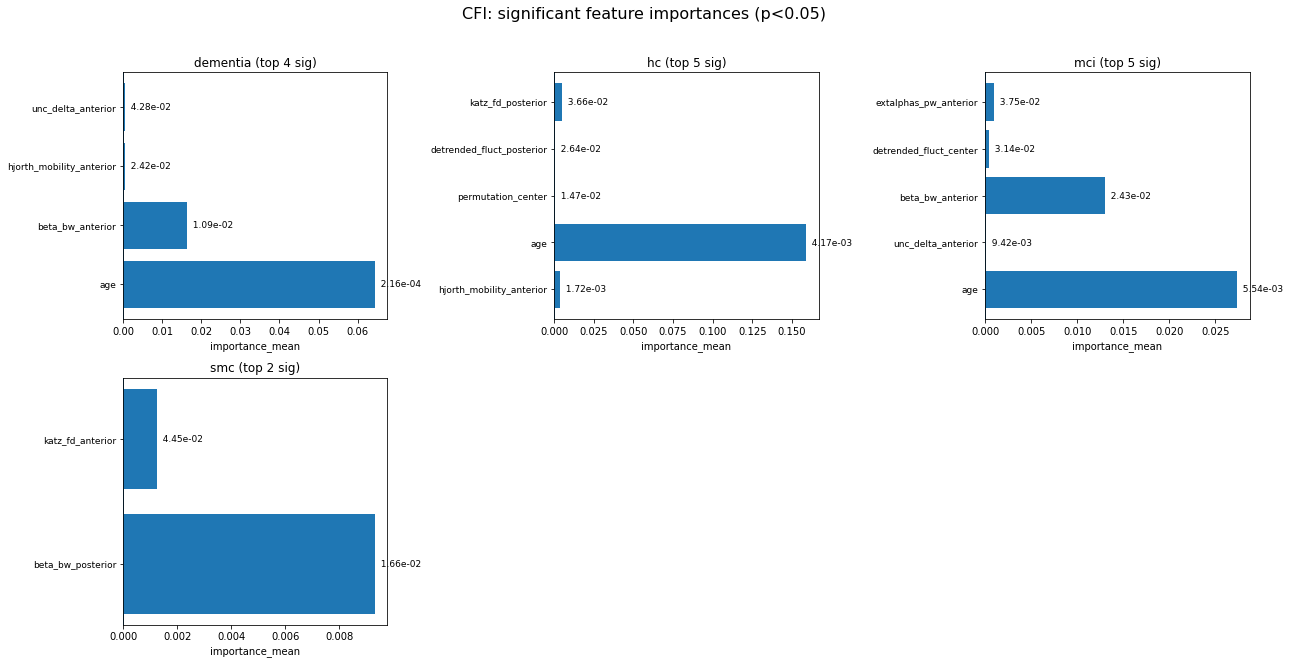

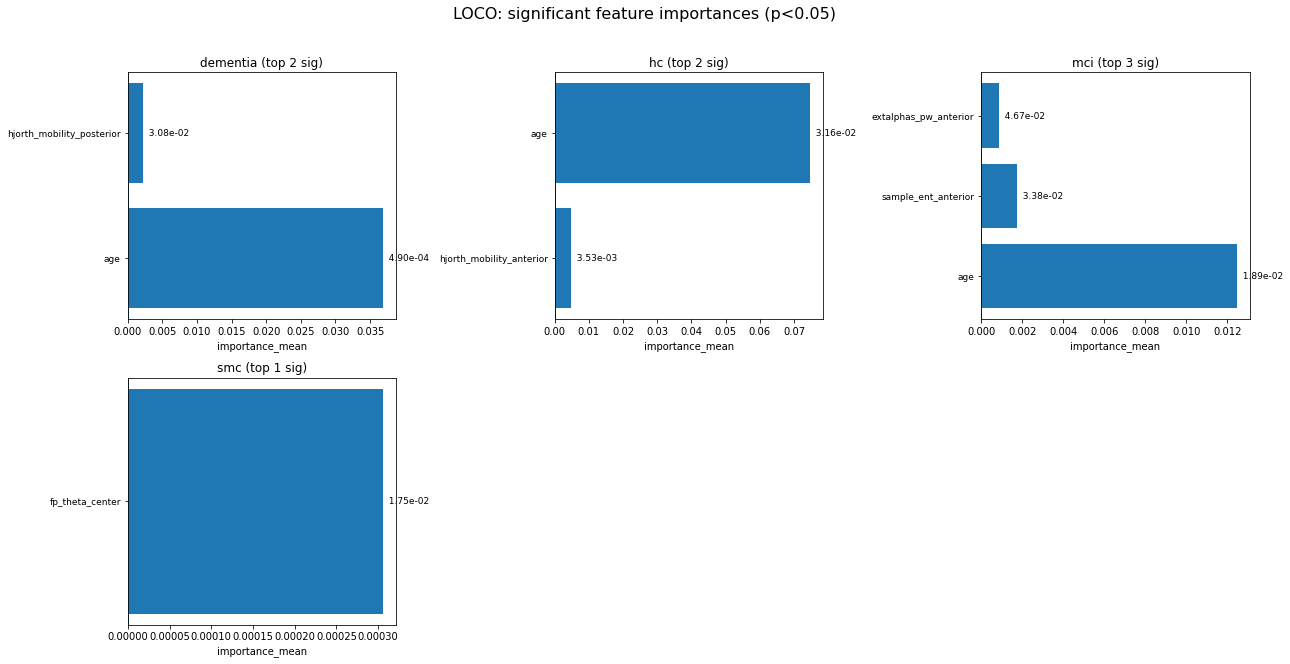

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# User controls
# -----------------------------
ALPHA = 0.05          # significance threshold
TOP_K = 20            # max number of significant features to show per class (per method)
METHODS = ["PFI", "CFI", "LOCO"]  # or any subset that exists in res_df

# -----------------------------
# Helper: BH-FDR within each (class, method) or globally
# -----------------------------
def bh_fdr(pvals: np.ndarray) -> np.ndarray:
    """
    Benjamini-Hochberg FDR correction.
    Returns q-values aligned with pvals.
    """
    p = np.asarray(pvals, dtype=float)
    n = p.size
    order = np.argsort(p)
    ranked = p[order]
    q = ranked * n / (np.arange(1, n + 1))
    q = np.minimum.accumulate(q[::-1])[::-1]  # enforce monotonicity
    q = np.clip(q, 0, 1)
    out = np.empty_like(q)
    out[order] = q
    return out

# Choose ONE:
USE_FDR = False         # if True, use q-values; if False, use raw p-values
FDR_SCOPE = "class_method"  # "class_method" or "global"

dfp = res_df.copy()

if USE_FDR:
    if FDR_SCOPE == "global":
        dfp["qval"] = bh_fdr(dfp["pval"].to_numpy())
    elif FDR_SCOPE == "class_method":
        dfp["qval"] = (
            dfp.groupby(["class_pos", "method"])["pval"]
               .transform(lambda s: bh_fdr(s.to_numpy()))
        )
    else:
        raise ValueError("FDR_SCOPE must be 'class_method' or 'global'")
    sig_mask = dfp["qval"] < ALPHA
    sig_label = f"q<{ALPHA} (BH, {FDR_SCOPE})"
else:
    sig_mask = dfp["pval"] < ALPHA
    sig_label = f"p<{ALPHA}"

df_sig = dfp.loc[sig_mask].copy()

print(f"Significant rows: {df_sig.shape[0]} / {dfp.shape[0]} using {sig_label}")

# -----------------------------
# Plotting
# -----------------------------
classes = sorted(df_sig["class_pos"].unique()) if len(df_sig) else sorted(res_df["class_pos"].unique())

for method in METHODS:
    d = df_sig[df_sig["method"] == method].copy()
    if d.empty:
        print(f"[{method}] No significant features at {sig_label}.")
        continue

    # Determine panel layout
    n_classes = len(classes)
    ncols = 3 if n_classes >= 3 else n_classes
    nrows = int(np.ceil(n_classes / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4.5*nrows))
    axes = np.atleast_1d(axes).ravel()

    for i, cls in enumerate(classes):
        ax = axes[i]
        d_cls = d[d["class_pos"] == cls].copy()

        if d_cls.empty:
            ax.axis("off")
            ax.text(0.5, 0.5, f"{cls}\n(no sig features)\n{sig_label}",
                    ha="center", va="center")
            continue

        # pick top K among significant: sort by (q/p) then by |importance|
        sort_cols = ["qval", "importance_mean"] if USE_FDR else ["pval", "importance_mean"]
        d_cls = d_cls.sort_values(sort_cols, ascending=[True, False]).head(TOP_K)

        # barplot: importance_mean
        y = np.arange(len(d_cls))[::-1]
        ax.barh(y, d_cls["importance_mean"].to_numpy()[::-1])
        ax.set_yticks(y)
        ax.set_yticklabels(d_cls["feature"].to_numpy()[::-1], fontsize=9)

        # annotate with p/q
        pv = d_cls["qval"].to_numpy() if USE_FDR else d_cls["pval"].to_numpy()
        pv = pv[::-1]
        imp = d_cls["importance_mean"].to_numpy()[::-1]
        for yy, (ii, pp) in enumerate(zip(imp, pv)):
            ax.text(ii, y[yy], f"  {pp:.2e}", va="center", fontsize=9)

        ax.axvline(0, linewidth=1)
        ax.set_title(f"{cls} (top {min(TOP_K, len(d_cls))} sig)")
        ax.set_xlabel("importance_mean")
        ax.set_ylabel("")

    # turn off unused panels
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.suptitle(f"{method}: significant feature importances ({sig_label})", y=1.02, fontsize=16)
    fig.tight_layout()
    plt.show()


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# -----------------------------
# 0) X/y
# -----------------------------
id_col = "participant_id"
target = "ad_syndrome"

drop_cols = [id_col, target, "center", "age"]
feature_cols = [c for c in df_wide.columns if c not in drop_cols]

X = df_wide[feature_cols].to_numpy()
y = df_wide[target].to_numpy()

print("X:", X.shape, " | classes:", pd.Series(y).value_counts().to_dict())

# -----------------------------
# 1) CV + scoring (imbalance-aware)
# -----------------------------
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    "bal_acc": "balanced_accuracy",
    "f1_macro": "f1_macro",
    "acc": "accuracy",
    # requires predict_proba; we'll only use it where available
    "auc_ovr_macro": "roc_auc_ovr_weighted",
}

# -----------------------------
# 2) Baseline models (no feature selection yet)
# -----------------------------
models = {
    "logreg_multinomial_balanced": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=5000,
            solver="saga",
            penalty="l2",
            C=1.0,
            class_weight="balanced",
            multi_class="multinomial",
            n_jobs=-1,
            random_state=42
        ))
    ]),
    "svm_rbf_balanced": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(
            kernel="rbf",
            C=1.0,
            gamma="scale",
            class_weight="balanced",
            probability=True,  # needed for AUC
            random_state=42
        ))
    ]),
    "rf_balanced_subsample": RandomForestClassifier(
        n_estimators=800,
        max_depth=None,
        min_samples_leaf=2,
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=42
    ),
}

# -----------------------------
# 3) Evaluate
# -----------------------------
rows = []
for name, model in models.items():
    # If model doesn't support proba, AUC scorer will fail; we can drop AUC in that case.
    # Here all three support proba (RF yes, SVC yes with probability=True, LogReg yes).
    cv_res = cross_validate(
        model, X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        error_score="raise"
    )

    rows.append({
        "model": name,
        "balanced_accuracy_mean": np.mean(cv_res["test_bal_acc"]),
        "balanced_accuracy_std":  np.std(cv_res["test_bal_acc"]),
        "f1_macro_mean":          np.mean(cv_res["test_f1_macro"]),
        "f1_macro_std":           np.std(cv_res["test_f1_macro"]),
        "accuracy_mean":          np.mean(cv_res["test_acc"]),
        "accuracy_std":           np.std(cv_res["test_acc"]),
        "auc_ovr_weighted_mean":  np.mean(cv_res["test_auc_ovr_macro"]),
        "auc_ovr_weighted_std":   np.std(cv_res["test_auc_ovr_macro"]),
    })

results_baseline = pd.DataFrame(rows).sort_values("balanced_accuracy_mean", ascending=False)
results_baseline


X: (949, 84)  | classes: {'mci': 318, 'hc': 241, 'dementia': 216, 'smc': 174}


c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-pa

X: (949, 84)  | classes: {'mci': 318, 'hc': 241, 'dementia': 216, 'smc': 174}


c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-pa

,model,balanced_accuracy_mean,balanced_accuracy_std,f1_macro_mean,f1_macro_std,accuracy_mean,accuracy_std,auc_ovr_weighted_mean,auc_ovr_weighted_std
0,logreg_multinomial_balanced,0.434228,0.048168,0.425516,0.043222,0.434166,0.047009,0.694055,0.025249
1,svm_rbf_balanced,0.427479,0.052099,0.414172,0.047584,0.425711,0.049844,0.688775,0.018692
2,rf_balanced_subsample,0.418011,0.040613,0.401635,0.045724,0.448959,0.035251,0.685624,0.021924


In [14]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score, accuracy_score, roc_auc_score


# -----------------------------
# Helpers: fold-specific age-bin weights (quantile bins)
# -----------------------------
def compute_agebin_weights_train_only(y_train, age_train, n_bins=10, clip=(0.25, 4.0), eps=1e-6):
    """
    Compute sample weights to make each class have the SAME age-bin distribution
    as the overall training distribution.

    Steps:
      - create quantile bins on *training ages* (ensures enough samples per bin)
      - compute p(bin) overall and p(bin | class)
      - weight each sample in class c, bin b by w = p(bin) / p(bin|c)
    Optionally clip weights to avoid huge variance.
    """
    y_train = np.asarray(y_train)
    age_train = np.asarray(age_train).astype(float)

    # Quantile edges (unique)
    qs = np.linspace(0, 1, n_bins + 1)
    edges = np.quantile(age_train, qs)

    # Make edges strictly increasing by jittering duplicates
    # (can happen if many ages are identical)
    for i in range(1, len(edges)):
        if edges[i] <= edges[i-1]:
            edges[i] = edges[i-1] + 1e-3

    # Bin index 0..n_bins-1
    bin_idx = np.digitize(age_train, edges[1:-1], right=True)

    # overall bin distribution
    n = len(age_train)
    p_bin = np.bincount(bin_idx, minlength=n_bins) / max(n, 1)

    # p(bin | class)
    classes = pd.unique(y_train)
    p_bin_given = {}
    for c in classes:
        mask = (y_train == c)
        bc = np.bincount(bin_idx[mask], minlength=n_bins)
        p = bc / max(bc.sum(), 1)
        p_bin_given[c] = p

    # weights
    w = np.empty(n, dtype=float)
    for i in range(n):
        c = y_train[i]
        b = bin_idx[i]
        denom = max(p_bin_given[c][b], eps)
        w[i] = p_bin[b] / denom

    # Normalize to mean 1 (nice numerically)
    w = w / np.mean(w)

    # Clip to avoid extreme weights
    if clip is not None:
        lo, hi = clip
        w = np.clip(w, lo, hi)
        w = w / np.mean(w)

    return w, edges


def fit_predict_with_optional_weights(model, X_train, y_train, X_test, use_age_weights=False, age_train=None):
    """
    Fit model, optionally using sample weights (age-bin weights).
    Returns predicted labels and predicted probabilities.
    """
    fit_params = {}

    if use_age_weights:
        assert age_train is not None
        w_train, _ = compute_agebin_weights_train_only(y_train=y_train, age_train=age_train, n_bins=10)
        # Attach sample_weight at the correct pipeline step, if pipeline
        if isinstance(model, Pipeline):
            last_step = model.steps[-1][0]
            fit_params[f"{last_step}__sample_weight"] = w_train
        else:
            fit_params["sample_weight"] = w_train

    model.fit(X_train, y_train, **fit_params)

    y_pred = model.predict(X_test)

    # Probabilities for AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
    else:
        y_proba = None

    return y_pred, y_proba


def evaluate_cv(models, X, y, ages, cv, use_age_weights=False, include_age_feature=False, random_state=42):
    """
    Manual CV loop so weights are computed inside each training fold only.
    """
    classes = np.unique(y)
    results = []

    for name, base_model in models.items():
        bal_accs, f1s, accs, aucs = [], [], [], []

        for fold, (tr, te) in enumerate(cv.split(X, y), start=1):
            X_tr, X_te = X[tr], X[te]
            y_tr, y_te = y[tr], y[te]
            age_tr, age_te = ages[tr], ages[te]

            # Optionally include age as a feature (last column)
            if include_age_feature:
                X_tr_use = np.column_stack([X_tr, age_tr])
                X_te_use = np.column_stack([X_te, age_te])
            else:
                X_tr_use, X_te_use = X_tr, X_te

            # Clone model by recreating (simple approach: use sklearn's clone if needed)
            from sklearn.base import clone
            model = clone(base_model)

            y_pred, y_proba = fit_predict_with_optional_weights(
                model,
                X_tr_use, y_tr,
                X_te_use,
                use_age_weights=use_age_weights,
                age_train=age_tr
            )

            bal_accs.append(balanced_accuracy_score(y_te, y_pred))
            f1s.append(f1_score(y_te, y_pred, average="macro"))
            accs.append(accuracy_score(y_te, y_pred))

            if y_proba is not None:
                # multiclass ovr weighted
                try:
                    auc = roc_auc_score(y_te, y_proba, multi_class="ovr", average="weighted")
                except Exception:
                    auc = np.nan
                aucs.append(auc)
            else:
                aucs.append(np.nan)

        results.append({
            "model": name,
            "age_weights": use_age_weights,
            "include_age_feature": include_age_feature,
            "balanced_accuracy_mean": float(np.nanmean(bal_accs)),
            "balanced_accuracy_std":  float(np.nanstd(bal_accs)),
            "f1_macro_mean":          float(np.nanmean(f1s)),
            "f1_macro_std":           float(np.nanstd(f1s)),
            "accuracy_mean":          float(np.nanmean(accs)),
            "accuracy_std":           float(np.nanstd(accs)),
            "auc_ovr_weighted_mean":  float(np.nanmean(aucs)),
            "auc_ovr_weighted_std":   float(np.nanstd(aucs)),
        })

    return pd.DataFrame(results)


# -----------------------------
# Data (from df_wide already created above in the session)
# -----------------------------
id_col = "participant_id"
target = "ad_syndrome"

drop_cols = [id_col, target, "center", "age"]
feature_cols = [c for c in df_wide.columns if c not in drop_cols]

X = df_wide[feature_cols].to_numpy().astype(float)
y = df_wide[target].to_numpy()
ages = df_wide["age"].to_numpy().astype(float)

# -----------------------------
# Models (same as before)
# -----------------------------
models = {
    "logreg_multinomial_balanced": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=5000,
            solver="saga",
            penalty="l2",
            C=1.0,
            class_weight="balanced",
            multi_class="multinomial",
            n_jobs=-1,
            random_state=42
        ))
    ]),
    "svm_rbf_balanced": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(
            kernel="rbf",
            C=1.0,
            gamma="scale",
            class_weight="balanced",
            probability=True,
            random_state=42
        ))
    ]),
    "rf_balanced_subsample": RandomForestClassifier(
        n_estimators=800,
        max_depth=None,
        min_samples_leaf=2,
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=42
    ),
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# -----------------------------
# Run 3 scenarios:
#  A) baseline
#  B) baseline + age-bin weights
#  C) baseline + age-bin weights + include age as feature
# -----------------------------
res_A = evaluate_cv(models, X, y, ages, cv, use_age_weights=False, include_age_feature=False)
res_B = evaluate_cv(models, X, y, ages, cv, use_age_weights=True,  include_age_feature=False)
res_C = evaluate_cv(models, X, y, ages, cv, use_age_weights=True,  include_age_feature=True)

results_agebalance = pd.concat([res_A, res_B, res_C], ignore_index=True)

# Sort for readability
results_agebalance_sorted = results_agebalance.sort_values(
    ["balanced_accuracy_mean", "f1_macro_mean"], ascending=False
).reset_index(drop=True)

results_agebalance_sorted



c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-pa

,model,age_weights,include_age_feature,balanced_accuracy_mean,balanced_accuracy_std,f1_macro_mean,f1_macro_std,accuracy_mean,accuracy_std,auc_ovr_weighted_mean,auc_ovr_weighted_std
0,logreg_multinomial_balanced,False,False,0.434228,0.048168,0.425516,0.043222,0.434166,0.047009,0.694055,0.025249
1,logreg_multinomial_balanced,True,True,0.428741,0.050251,0.420817,0.049616,0.422587,0.053647,0.686248,0.028376
2,svm_rbf_balanced,False,False,0.427479,0.052099,0.414172,0.047584,0.425711,0.049844,0.688775,0.018692
3,svm_rbf_balanced,True,True,0.425356,0.060499,0.413367,0.060625,0.413080,0.063721,0.692466,0.028966
4,rf_balanced_subsample,True,True,0.424202,0.047395,0.413946,0.051041,0.458410,0.045295,0.702727,0.026735
5,logreg_multinomial_balanced,True,False,0.422110,0.047680,0.414733,0.048246,0.417301,0.050460,0.670131,0.028324
6,rf_balanced_subsample,False,False,0.418011,0.040613,0.401635,0.045724,0.448959,0.035251,0.685624,0.021924
7,svm_rbf_balanced,True,False,0.406617,0.055017,0.396163,0.055700,0.395185,0.057152,0.671688,0.028613
8,rf_balanced_subsample,True,False,0.406319,0.054329,0.400565,0.056694,0.437357,0.054607,0.686034,0.026485


c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2212951586848817, tolerance: 0.07475414735216566
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13055962999771964, tolerance: 0.07535400846953431
  model = cd_fast.enet_coordinate_descent_gram(


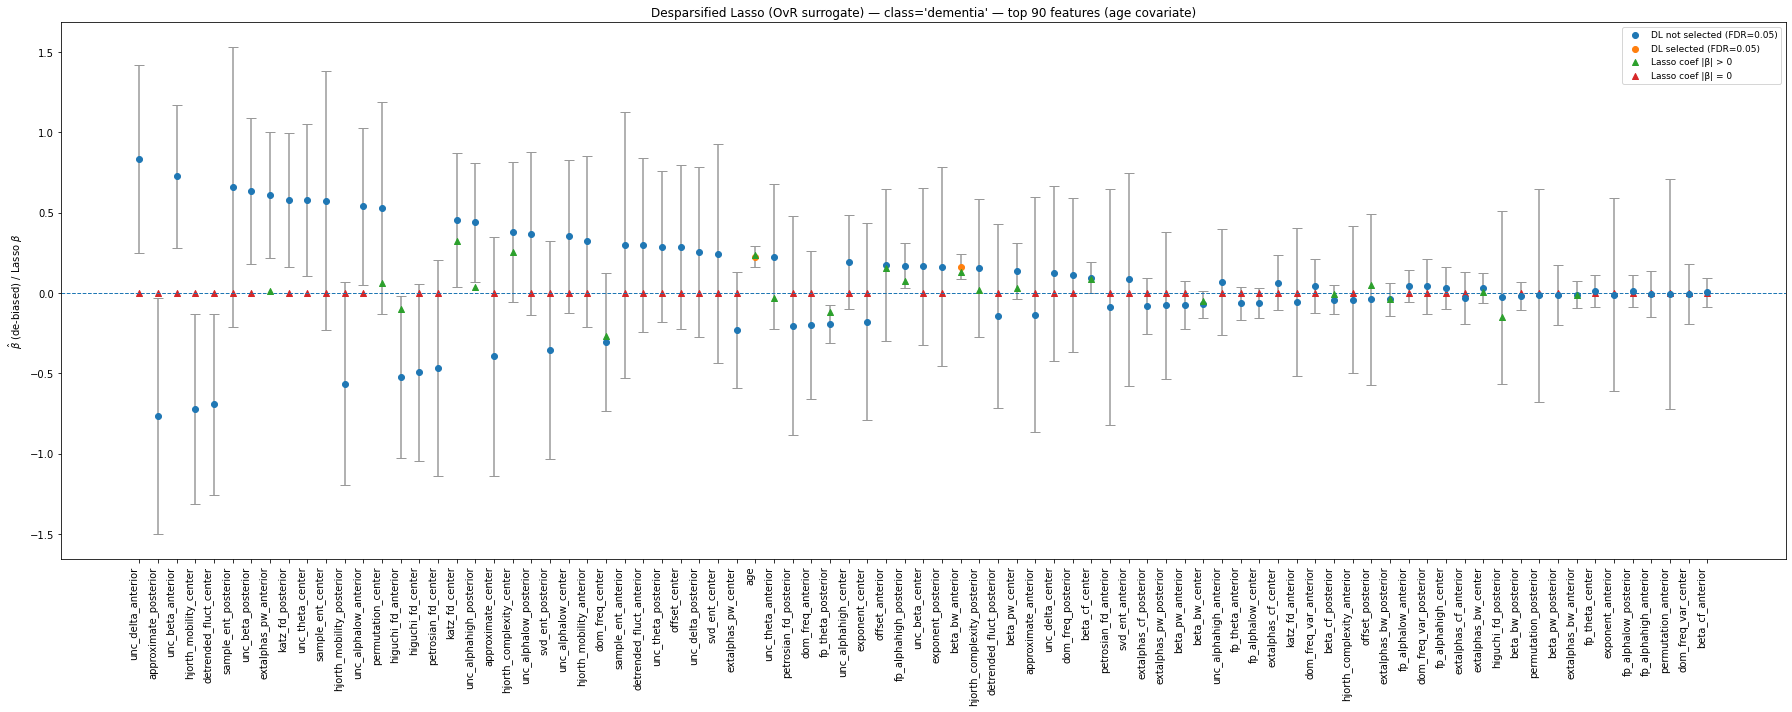

c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08626239706399019, tolerance: 0.07699151941168239
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08087854181121656, tolerance: 0.08087468364018857
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08619352317913354, tolerance: 0.08137734086880914
  model = cd_fast.enet_coordinate_descent_gram(
c:\User

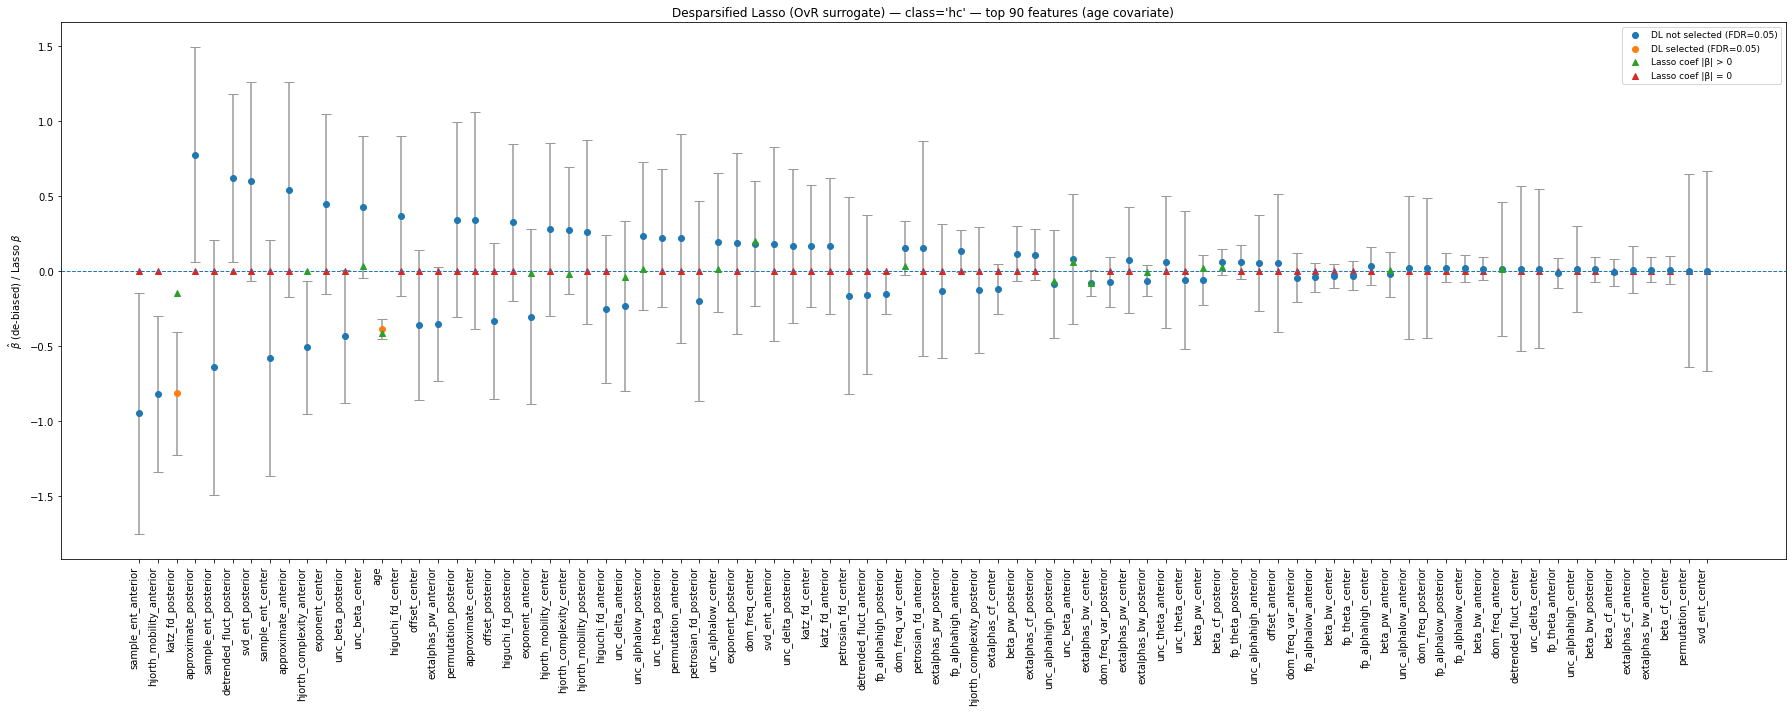

c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10621762045627747, tolerance: 0.07478269015623709
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12823821070674057, tolerance: 0.07353565710850775
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12427638154895249, tolerance: 0.07478269015623709
  model = cd_fast.enet_coordinate_descent_gram(
c:\User

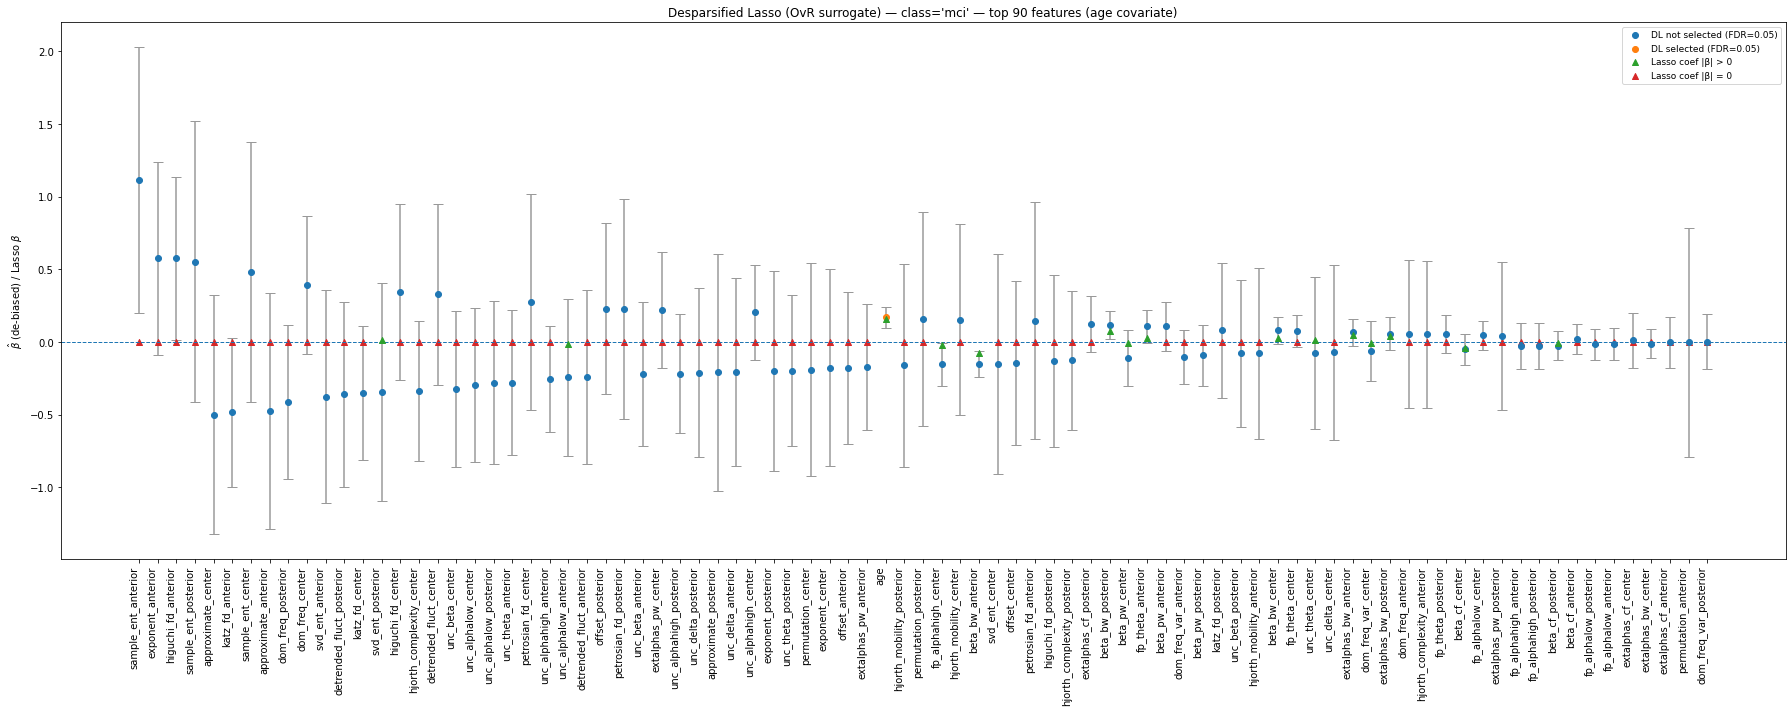

c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09402504167292136, tolerance: 0.07916048658368761
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16980383681095645, tolerance: 0.07916048658368761
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14768853506006963, tolerance: 0.07500263055539294
  model = cd_fast.enet_coordinate_descent_gram(
c:\User

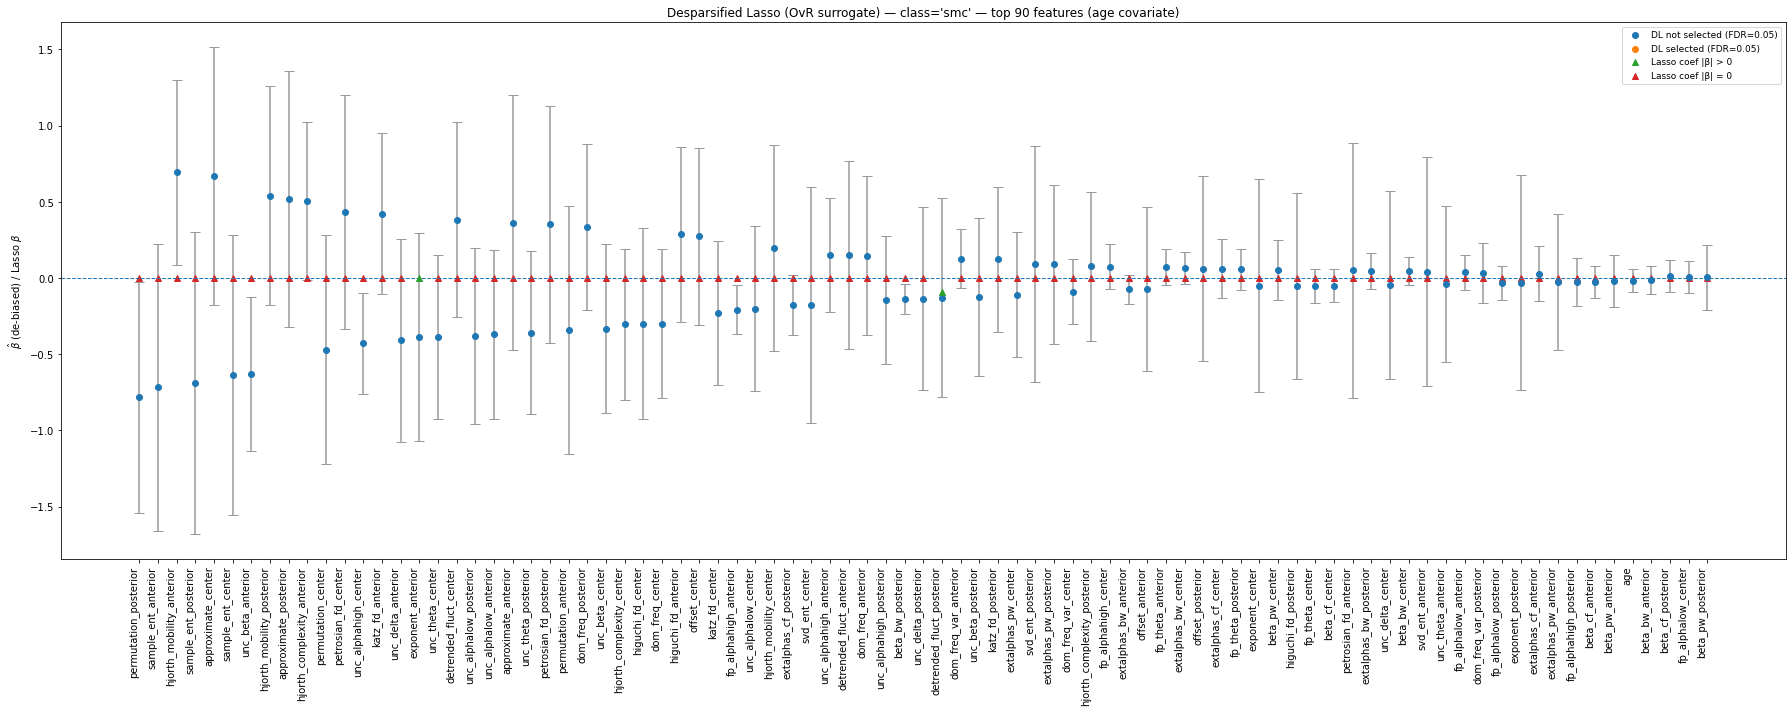

,class,n_selected_fdr0.1
0,dementia,2
1,hc,2
2,mci,1
3,smc,0


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

from hidimstat import DesparsifiedLasso

# -----------------------------
# Settings
# -----------------------------
fdr = 0.05
confidence = 0.95
top_k_plot = 90
random_state = 42

# -----------------------------
# Data
# -----------------------------
id_col = "participant_id"
target = "ad_syndrome"

# IMPORTANT: do NOT drop age anymore
drop_cols = [id_col, target, "center"]   ### <<<
feature_cols = [c for c in df_wide.columns if c not in drop_cols]

# Separate out age explicitly (clean numeric)
age = df_wide["age"].astype(float).to_numpy().reshape(-1, 1)  ### <<<

# EEG features only (no age)
eeg_cols = [c for c in feature_cols if c != "age"]            ### <<<
X_eeg = df_wide[eeg_cols].to_numpy()

# Append age as last column
X_raw = np.column_stack([X_eeg, age])                         ### <<<
feature_cols = eeg_cols + ["age"]                             ### <<<

y_raw = df_wide[target].to_numpy()
classes = sorted(pd.unique(y_raw))

# Standardize X once (DL example scales X)
X = StandardScaler().fit_transform(X_raw)

def desparsified_lasso_ovr(one_class: str):
    """Run DesparsifiedLasso on a one-vs-rest *regression* surrogate (standardized binary target)."""
    y_bin = (y_raw == one_class).astype(float)
    y = StandardScaler().fit_transform(y_bin.reshape(-1, 1)).ravel()

    dl = DesparsifiedLasso(
        estimator=LassoCV(max_iter=5000),
        confidence=confidence,
        model_x=LassoCV(max_iter=5000),
        n_jobs=-1,
        random_state=random_state,
    )
    dl.fit_importance(X, y)

    selected = dl.fdr_selection(fdr=fdr, two_tailed_test=True)

    df_plot = pd.DataFrame(
        {
            "feature": feature_cols,
            "importance": dl.importances_,  # debiased coef
            "selected": selected.astype(bool),
            "lasso_coef": dl.estimator.coef_,
            "confidence_min": dl.confidence_bound_min_,
            "confidence_max": dl.confidence_bound_max_,
        }
    ).sort_values(by="importance", key=np.abs, ascending=False)

    return df_plot, dl

# -----------------------------
# Run + plot for each class
# -----------------------------
all_results = {}
for c in classes:
    df_plot, _ = desparsified_lasso_ovr(c)
    all_results[c] = df_plot

    df_top = df_plot.head(top_k_plot).copy()
    x = np.arange(len(df_top))

    yhat = df_top["importance"].to_numpy()
    yerr_low = yhat - df_top["confidence_min"].to_numpy()
    yerr_high = df_top["confidence_max"].to_numpy() - yhat

    fig, ax = plt.subplots(figsize=(25, 10))
    ax.errorbar(
        x=x,
        y=yhat,
        yerr=[yerr_low, yerr_high],
        fmt="none",
        ecolor="0.6",
        elinewidth=1.5,
        capsize=5,
        zorder=1,
    )

    sel = df_top["selected"].to_numpy()
    ax.scatter(x[~sel], yhat[~sel], marker="o", label=f"DL not selected (FDR={fdr})", zorder=3)
    ax.scatter(x[sel],  yhat[sel],  marker="o", label=f"DL selected (FDR={fdr})", zorder=4)

    lasso_coef = df_top["lasso_coef"].to_numpy()
    nonzero = np.abs(lasso_coef) > 1e-6
    ax.scatter(x[nonzero],  lasso_coef[nonzero],  marker="^", label="Lasso coef |β| > 0", zorder=5)
    ax.scatter(x[~nonzero], lasso_coef[~nonzero], marker="^", label="Lasso coef |β| = 0", zorder=2)

    ax.axhline(0, linestyle="--", linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(df_top["feature"].tolist(), rotation=90, ha="right")
    ax.set_ylabel(r"$\hat{\beta}$ (de-biased) / Lasso $\beta$")
    ax.set_title(f"Desparsified Lasso (OvR surrogate) — class='{c}' — top {top_k_plot} features (age covariate)")
    ax.legend(loc="best", fontsize=9)
    plt.tight_layout()
    plt.show()

sel_counts = {c: int(all_results[c]["selected"].sum()) for c in classes}
pd.DataFrame({"class": list(sel_counts.keys()), "n_selected_fdr0.1": list(sel_counts.values())})


X: (949, 85)  | classes: {'mci': 318, 'hc': 241, 'dementia': 216, 'smc': 174}


Computing importance scores over folds: 100%|██████████| 10/10 [00:00<00:00, 5016.51it/s]
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\hidimstat\statistical_tools\nadeau_bengio_ttest.py:89: RuntimeWarning: invalid value encountered in divide
  t = np.divide(d, denom)
Computing importance scores over folds: 100%|██████████| 10/10 [00:00<00:00, 4998.57it/s]
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\hidimstat\statistical_tools\nadeau_bengio_ttest.py:89: RuntimeWarning: invalid value encountered in divide
  t = np.divide(d, denom)
Computing importance scores over folds: 100%|██████████| 10/10 [00:00<00:00, 10046.24it/s]
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13055962999771964, tolerance: 0.07535400846953431
  model = cd_fast.enet_coordinate_descent_gr

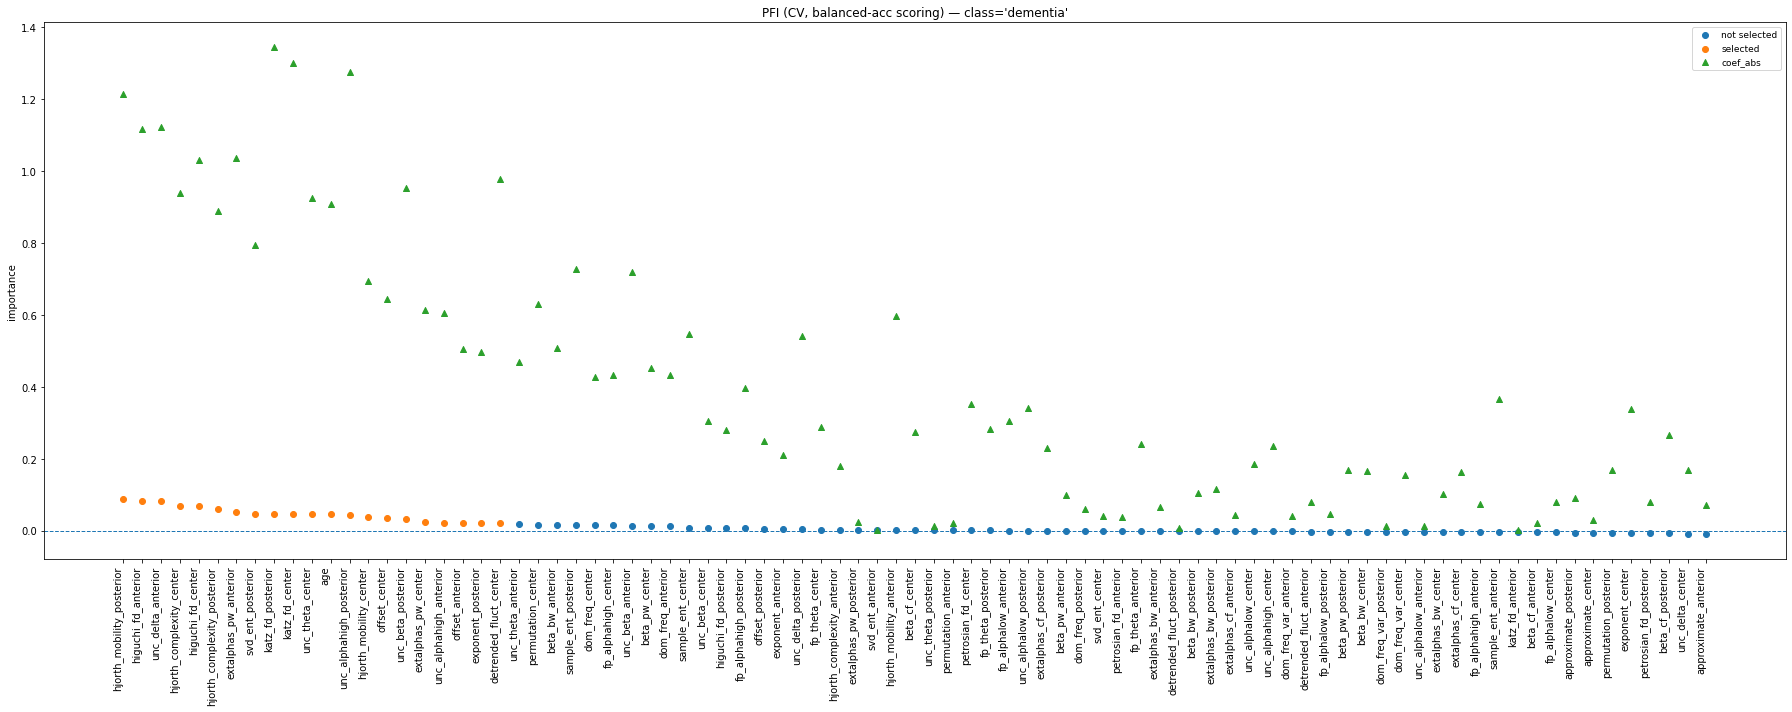

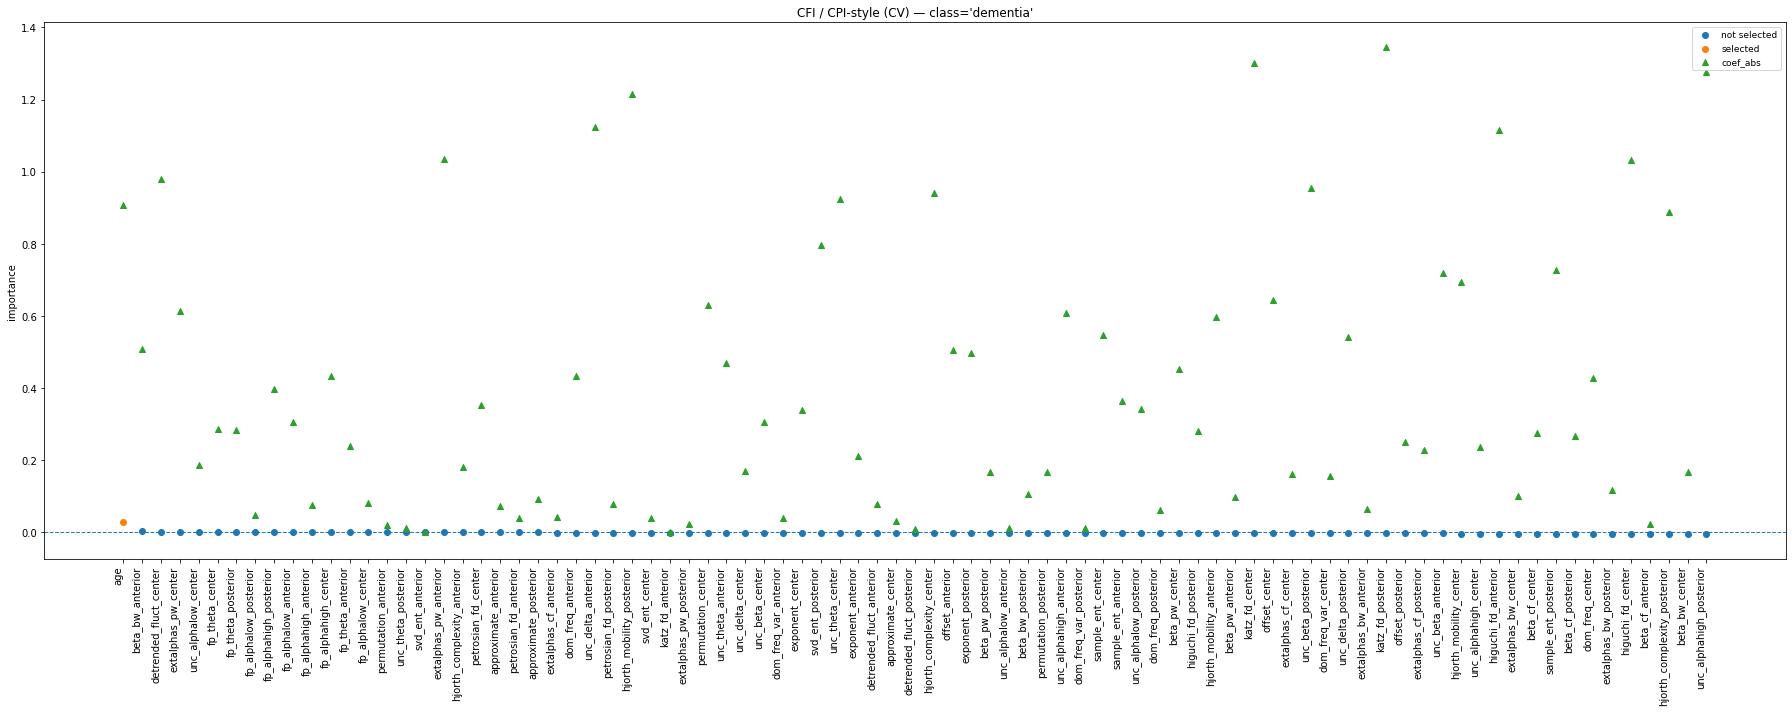

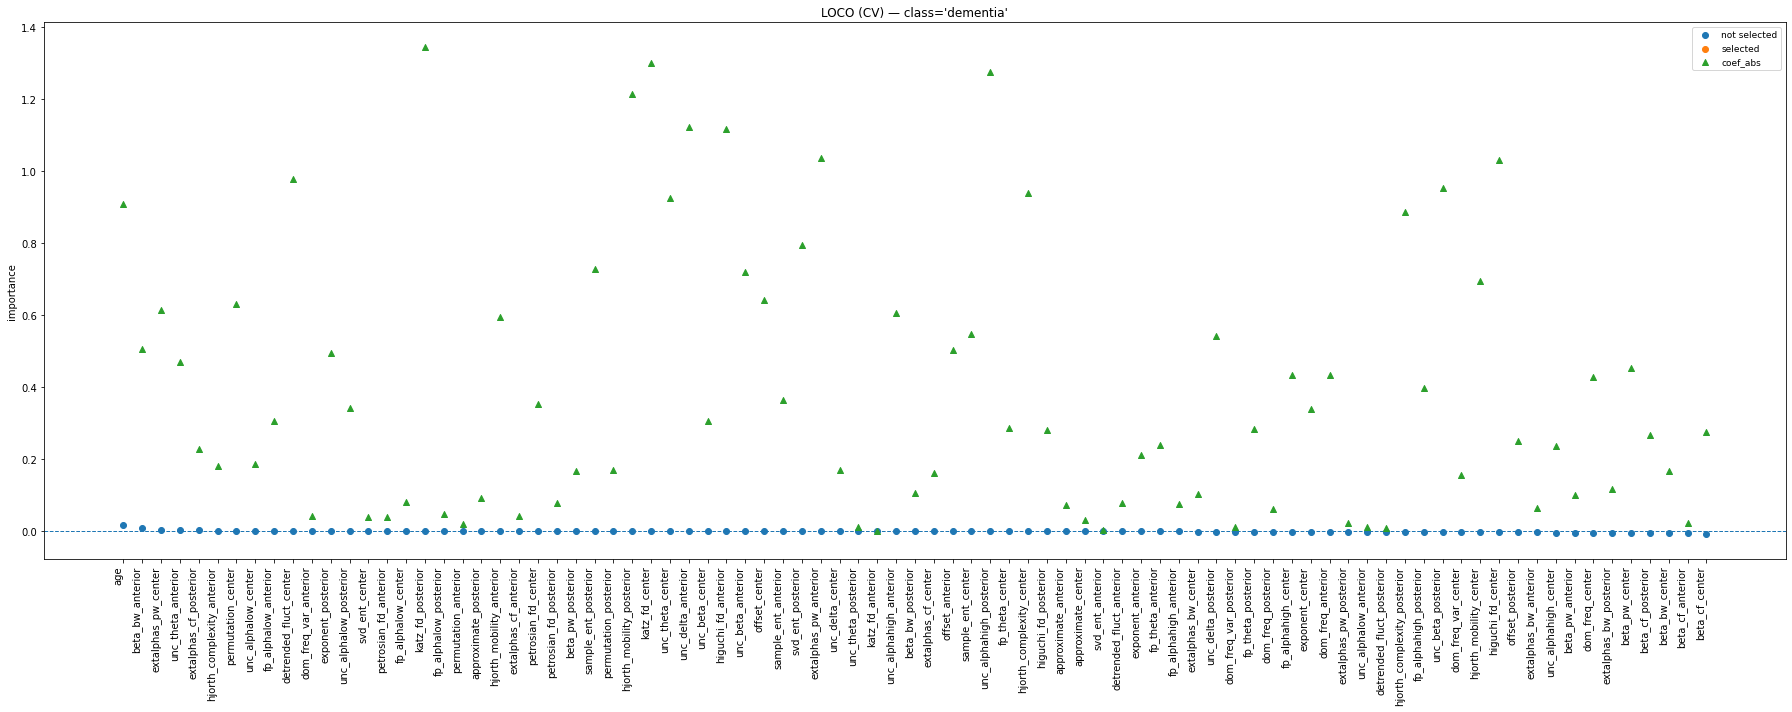

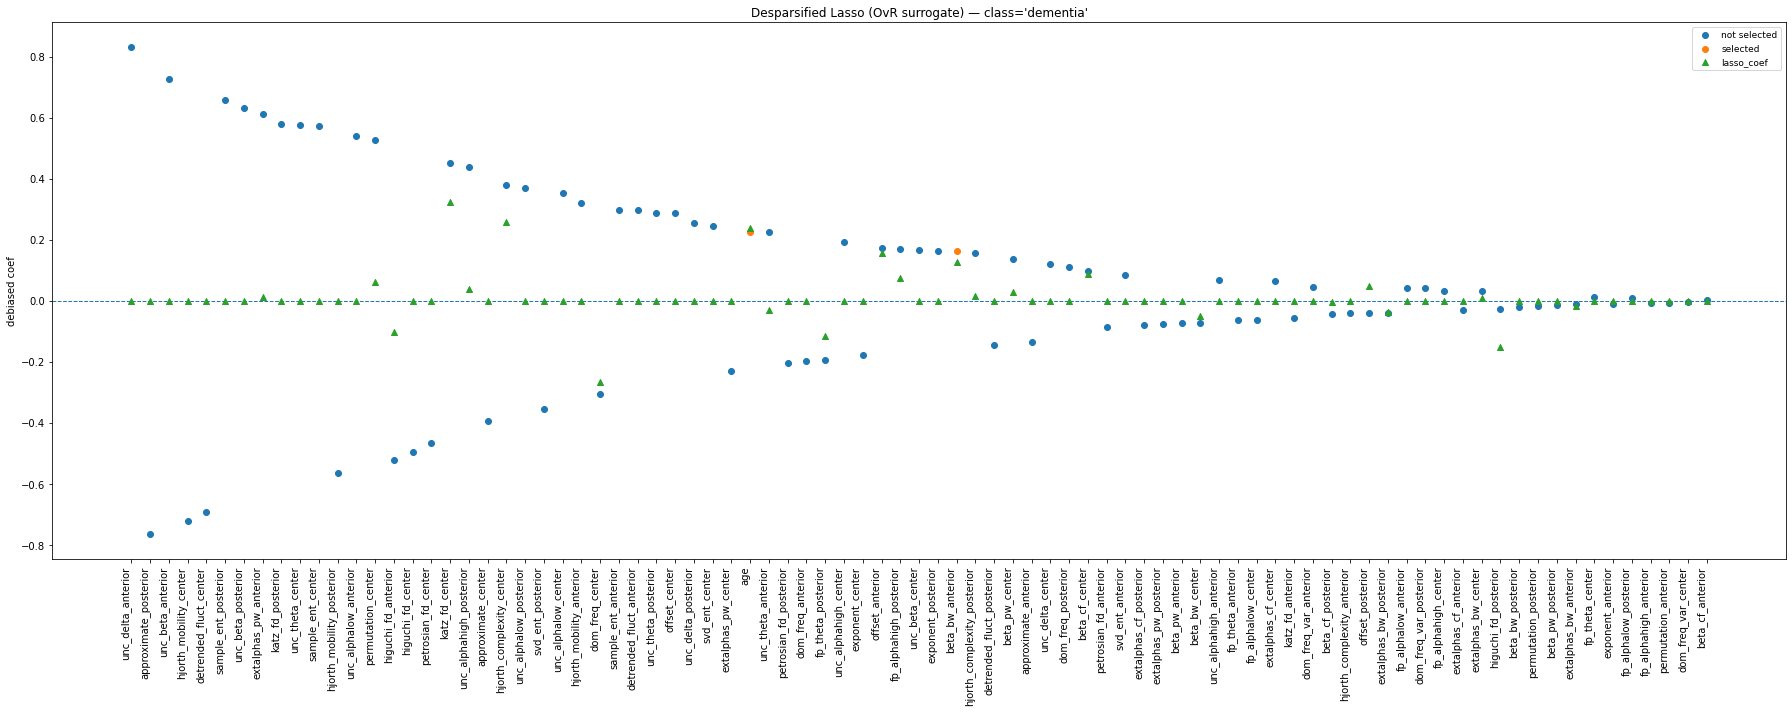

Computing importance scores over folds: 100%|██████████| 10/10 [00:00<00:00, 5017.11it/s]
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\hidimstat\statistical_tools\nadeau_bengio_ttest.py:89: RuntimeWarning: invalid value encountered in divide
  t = np.divide(d, denom)
Computing importance scores over folds: 100%|██████████| 10/10 [00:00<00:00, 5015.31it/s]
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\hidimstat\statistical_tools\nadeau_bengio_ttest.py:89: RuntimeWarning: invalid value encountered in divide
  t = np.divide(d, denom)
Computing importance scores over folds: 100%|██████████| 10/10 [00:00<00:00, 10080.04it/s]
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08140852194514991, tolerance: 0.05993035336903008
  model = cd_fast.enet_coordinate_descent_gr

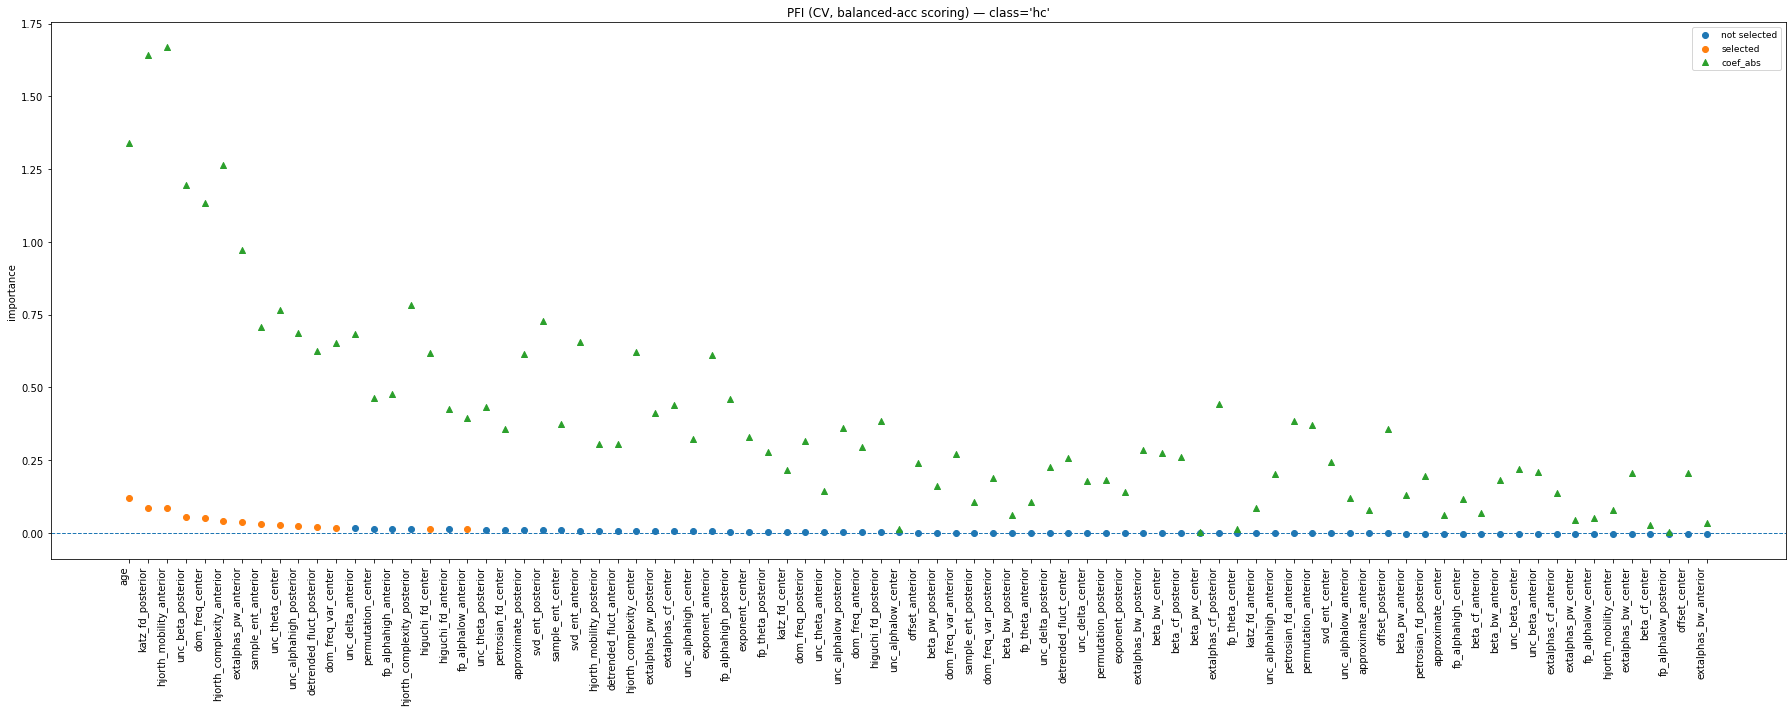

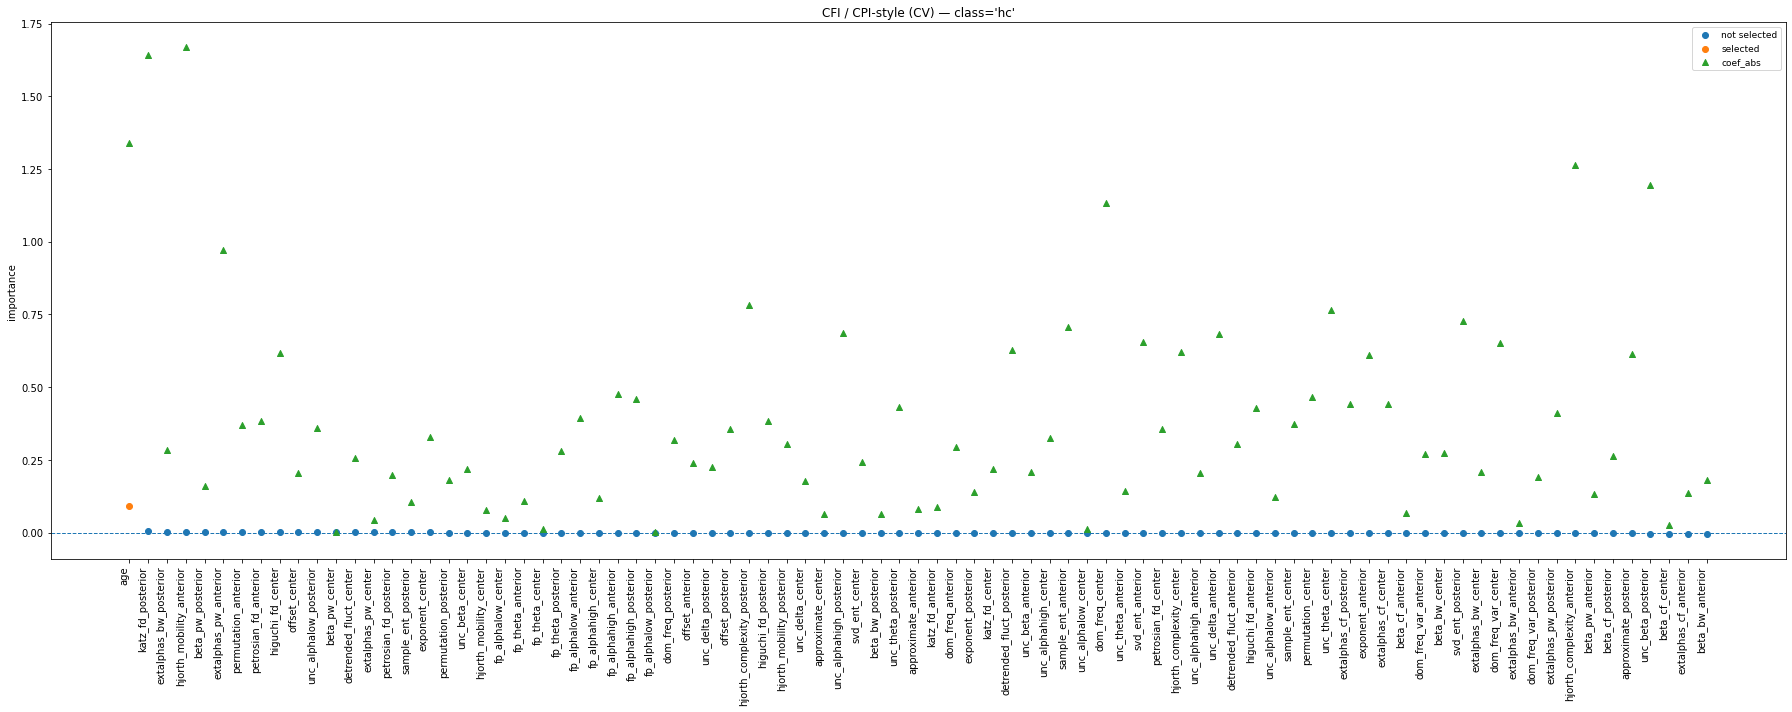

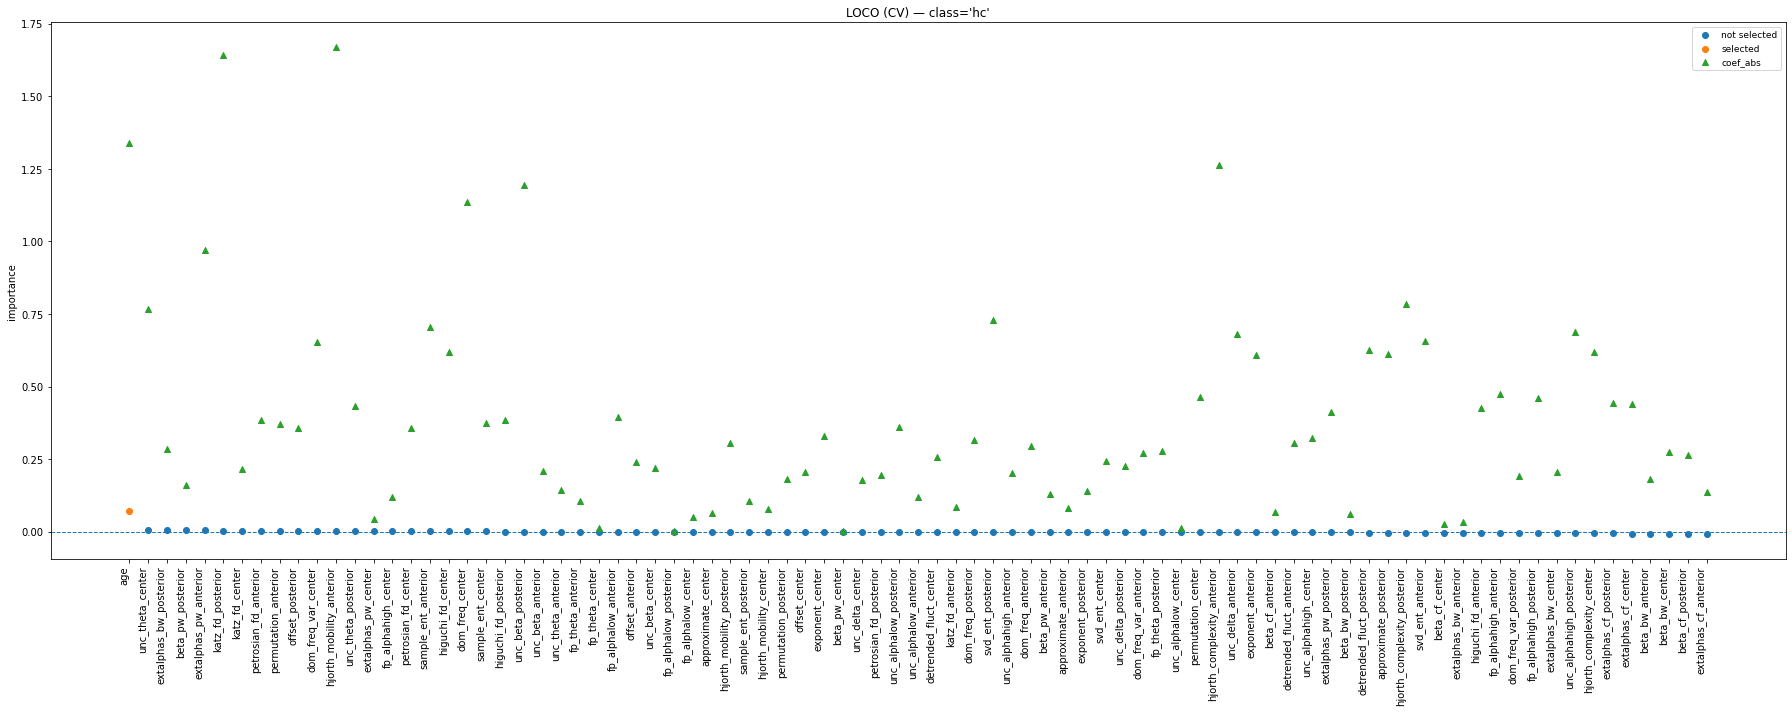

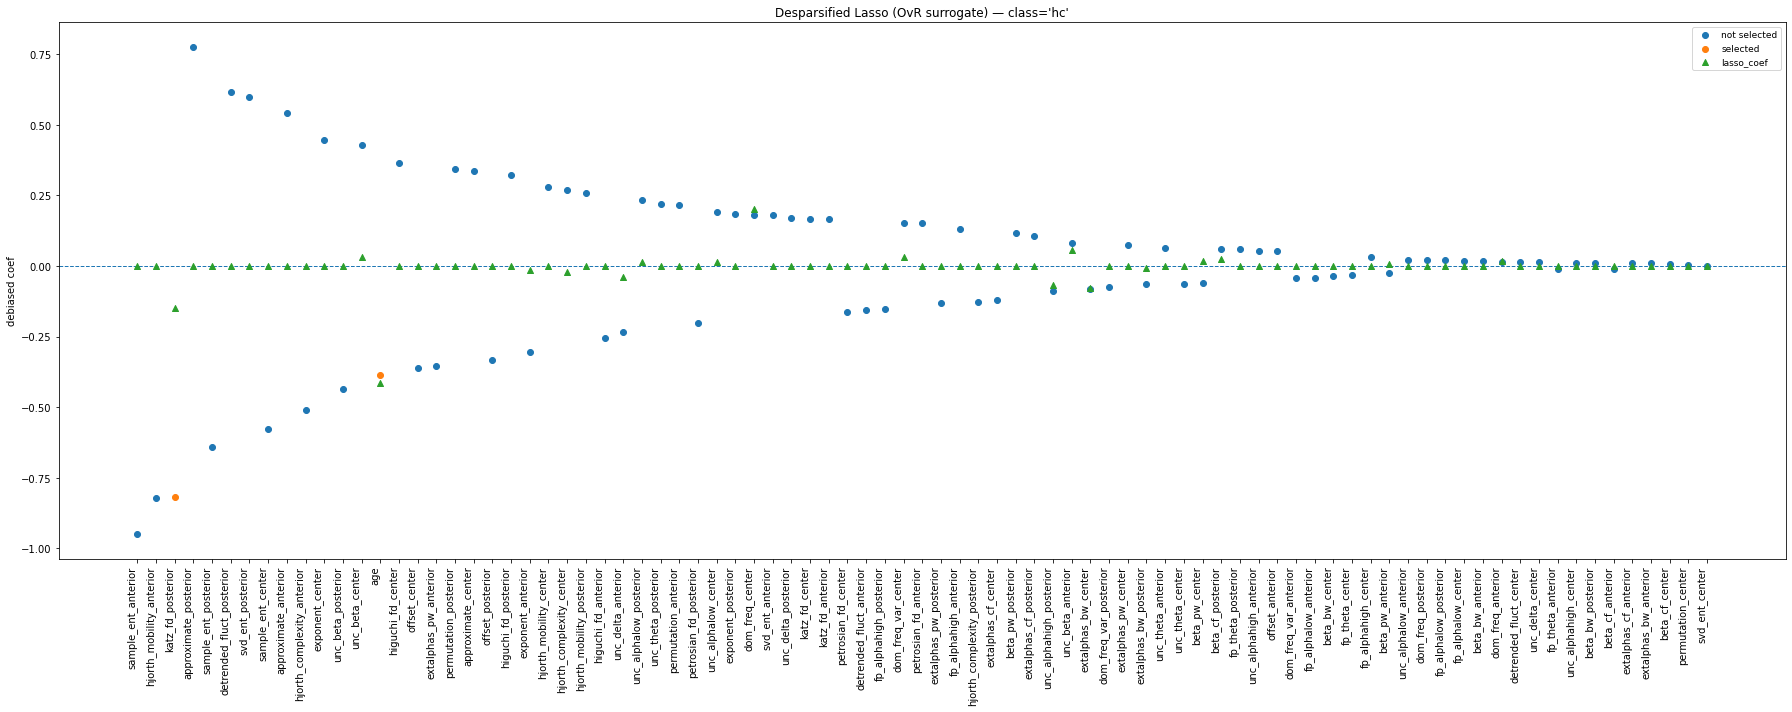

Computing importance scores over folds: 100%|██████████| 10/10 [00:00<00:00, 5016.51it/s]
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\hidimstat\statistical_tools\nadeau_bengio_ttest.py:89: RuntimeWarning: invalid value encountered in divide
  t = np.divide(d, denom)
Computing importance scores over folds: 100%|██████████| 10/10 [00:00<00:00, 10075.20it/s]
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\hidimstat\statistical_tools\nadeau_bengio_ttest.py:89: RuntimeWarning: invalid value encountered in divide
  t = np.divide(d, denom)
Computing importance scores over folds: 100%|██████████| 10/10 [00:00<00:00, 10031.82it/s]
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12427638154895249, tolerance: 0.07478269015623709
  model = cd_fast.enet_coordinate_descent_g

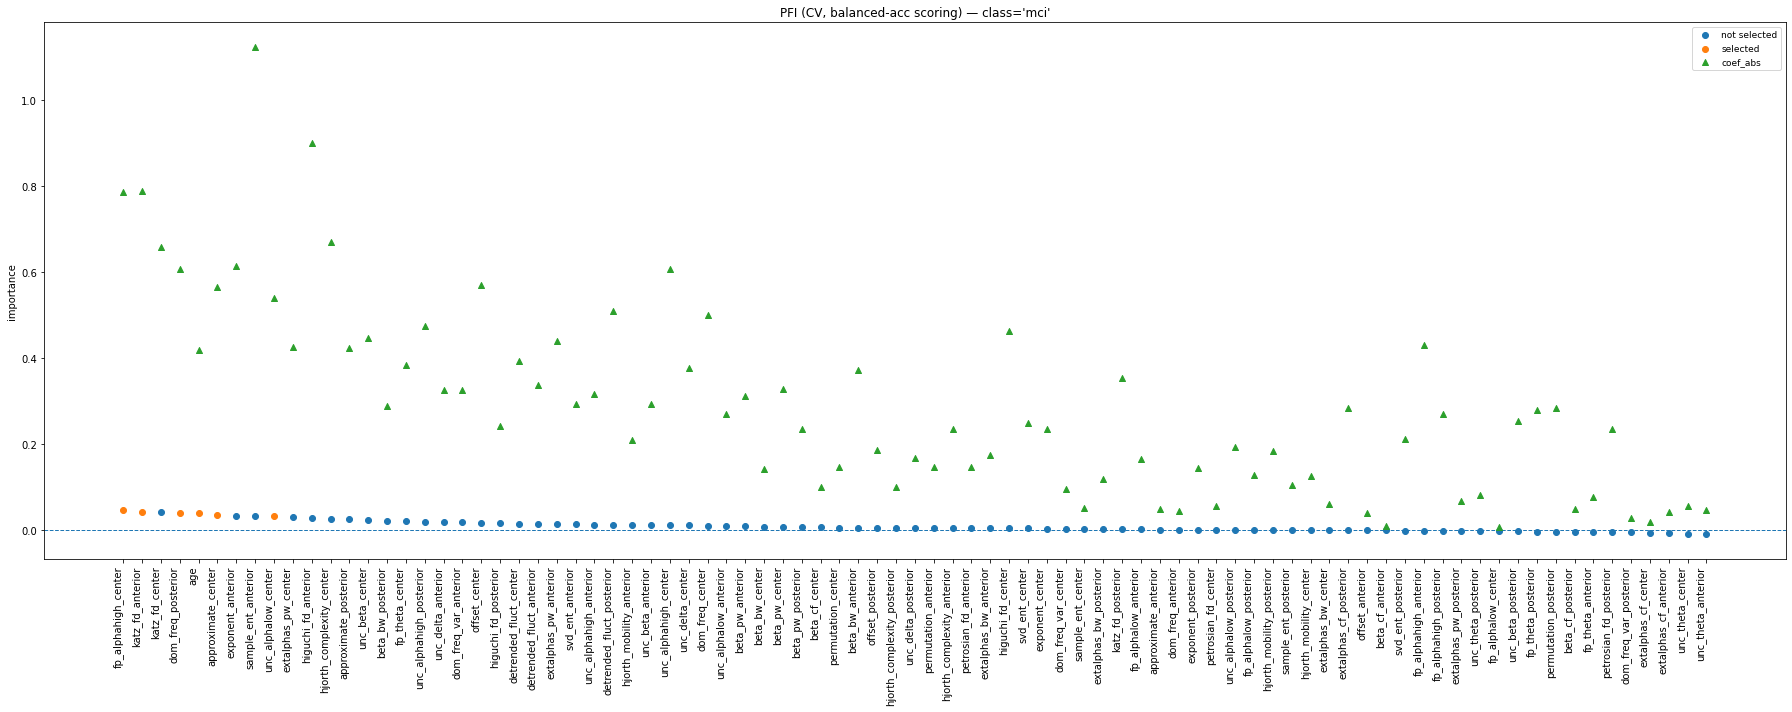

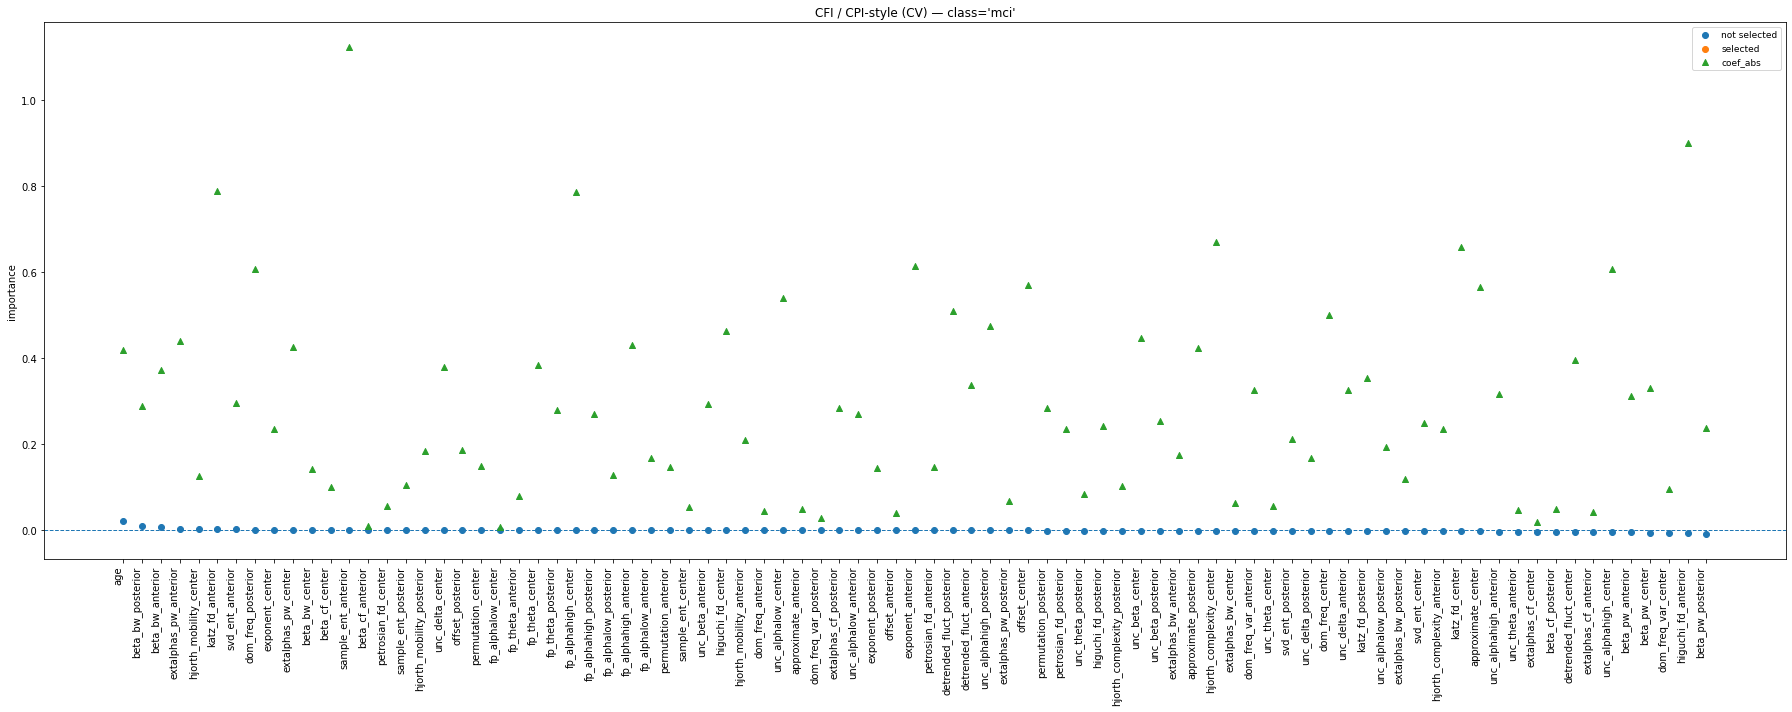

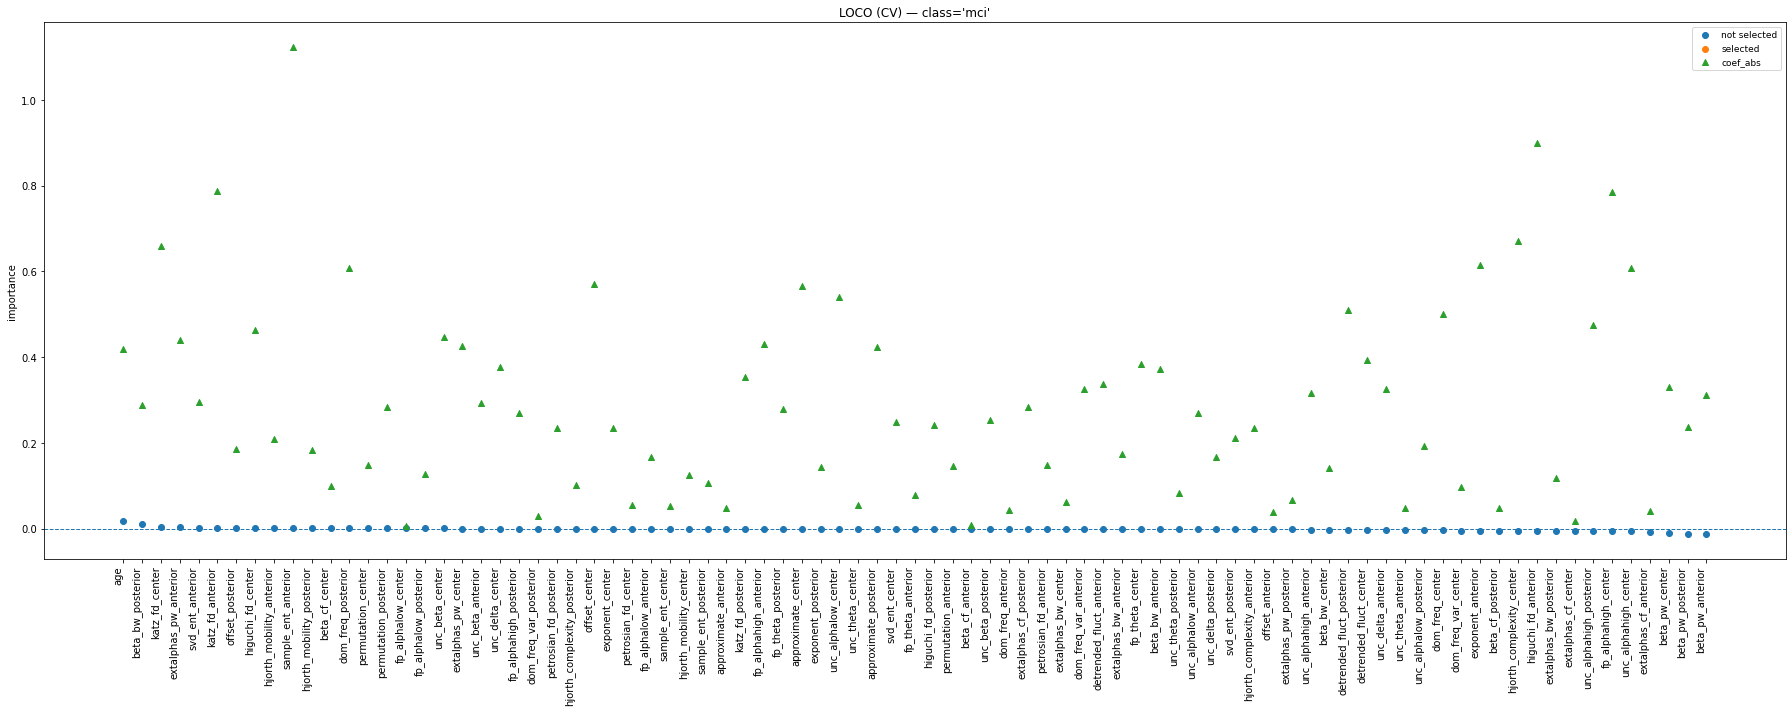

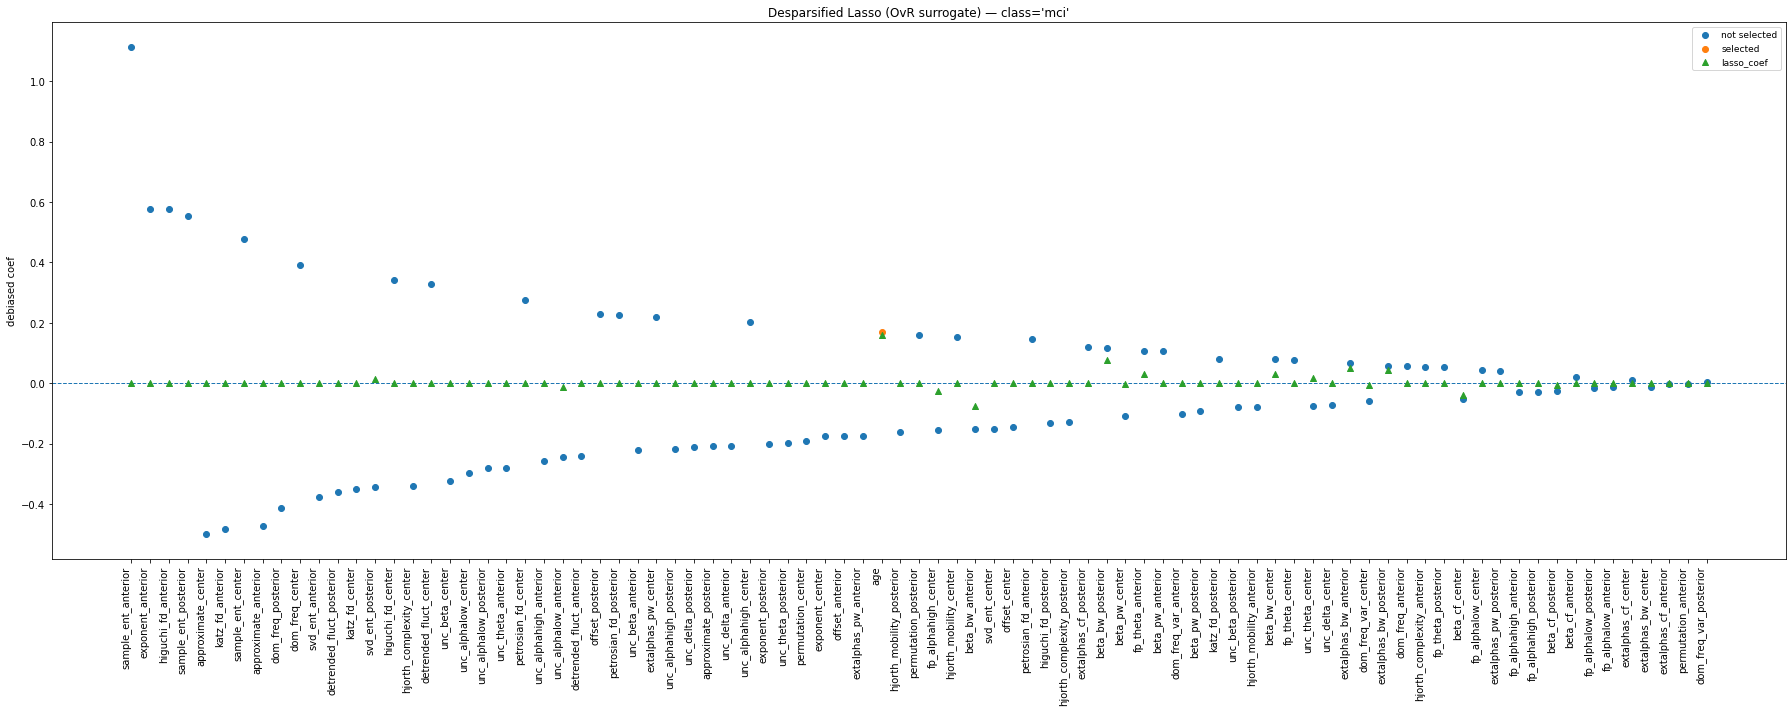

Computing importance scores over folds: 100%|██████████| 10/10 [00:00<00:00, 5032.76it/s]
c:\Users\sesam_analysis\anaconda3\envs\eeg_sensor\lib\site-packages\hidimstat\statistical_tools\nadeau_bengio_ttest.py:89: RuntimeWarning: invalid value encountered in divide
  t = np.divide(d, denom)
Fitting importance estimators for each fold: 100%|██████████| 10/10 [00:00<00:00, 2505.86it/s]


KeyboardInterrupt: 

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold

from hidimstat import PFICV, LOCOCV, CFICV, DesparsifiedLasso


# -----------------------------
# Settings
# -----------------------------
alpha = 0.05
fdr_dl = 0.05
confidence = 0.95
top_k_plot = 90
random_state = 42

n_splits = 10
n_jobs = -1
statistical_test = "nb-ttest"


# -----------------------------
# Data: X with age covariate
# -----------------------------
id_col = "participant_id"
target = "ad_syndrome"

drop_cols = [id_col, target, "center"]  # KEEP age
feature_cols0 = [c for c in df_wide.columns if c not in drop_cols]

eeg_cols = [c for c in feature_cols0 if c != "age"]
age = df_wide["age"].astype(float).to_numpy().reshape(-1, 1)

X_eeg = df_wide[eeg_cols].to_numpy()
X_raw = np.column_stack([X_eeg, age])
feature_cols = eeg_cols + ["age"]

y_raw = df_wide[target].to_numpy()
classes = sorted(pd.unique(y_raw))

print("X:", X_raw.shape, " | classes:", pd.Series(y_raw).value_counts().to_dict())


# -----------------------------
# Balanced accuracy wrapper (so estimator.score = balanced_acc)
# -----------------------------
class BalancedAccuracyWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator):
        self.base_estimator = base_estimator

    def fit(self, X, y):
        self.est_ = clone(self.base_estimator)
        self.est_.fit(X, y)
        return self

    def predict(self, X):
        return self.est_.predict(X)

    def score(self, X, y):
        return balanced_accuracy_score(y, self.predict(X))


# base model
base_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        solver="saga",
        penalty="l2",
        C=1.0,
        max_iter=5000,
        class_weight="balanced",
        random_state=random_state,
        n_jobs=-1
    ))
])
scored_clf = BalancedAccuracyWrapper(base_clf)

cv_bin = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)


# -----------------------------
# Fit one estimator per fold (IMPORTANT: fitted!)
# -----------------------------
def fit_estimators_per_fold(X, y, cv, estimator):
    fitted = []
    for tr, te in cv.split(X, y):
        est = clone(estimator)
        est.fit(X[tr], y[tr])
        fitted.append(est)
    return fitted


# -----------------------------
# Plot helper (DL-like)
# -----------------------------
def plot_importance_like_dl(df_plot, title, y_label="importance", tri_col=None):
    df_top = df_plot.head(top_k_plot).copy()
    x = np.arange(len(df_top))
    y = df_top["importance"].to_numpy()
    sel = df_top["selected"].to_numpy().astype(bool)

    fig, ax = plt.subplots(figsize=(25, 10))
    ax.scatter(x[~sel], y[~sel], marker="o", zorder=3, label="not selected")
    ax.scatter(x[sel],  y[sel],  marker="o", zorder=4, label="selected")

    if tri_col is not None and tri_col in df_top.columns:
        tri = df_top[tri_col].to_numpy()
        ax.scatter(x, tri, marker="^", zorder=5, label=tri_col)

    ax.axhline(0, linestyle="--", linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(df_top["feature"].tolist(), rotation=90, ha="right")
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend(loc="best", fontsize=9)
    plt.tight_layout()
    plt.show()


# -----------------------------
# PFI / LOCO / CFI (OvR)
# -----------------------------
def run_cv_vim_methods_ovr(one_class: str):
    y_bin = (y_raw == one_class).astype(int)

    fitted_estimators = fit_estimators_per_fold(X_raw, y_bin, cv_bin, scored_clf)

    cfi = CFICV(
        estimators=fitted_estimators,
        cv=cv_bin,
        statistical_test=statistical_test,
        n_jobs=n_jobs,
        random_state=random_state,
    )
    cfi.fit_importance(X_raw, y_bin)

    loco = LOCOCV(
        estimators=fitted_estimators,
        cv=cv_bin,
        statistical_test=statistical_test,
        n_jobs=n_jobs,
    )
    loco.fit_importance(X_raw, y_bin)

    pfi = PFICV(
        estimators=fitted_estimators,
        cv=cv_bin,
        statistical_test=statistical_test,
        n_jobs=n_jobs,
        random_state=random_state,
    )
    pfi.fit_importance(X_raw, y_bin)

    def summarize(vim, method_name):
        imp = np.asarray(vim.importances_)
        imp_mean = imp if imp.ndim == 1 else imp.mean(axis=1)

        pvals = np.asarray(vim.pvalues_).ravel()
        selected = (pvals < alpha)

        # triangles: refit base_clf on full data for this OvR to show |coef|
        coef_abs = np.full(len(feature_cols), np.nan)
        try:
            tmp = clone(base_clf).fit(X_raw, y_bin)
            lr = tmp.named_steps["clf"]
            coef_abs = np.abs(lr.coef_).ravel()
        except Exception:
            pass

        return (
            pd.DataFrame({
                "feature": feature_cols,
                "importance": imp_mean,
                "pvalue": pvals,
                "selected": selected,
                "coef_abs": coef_abs,
                "method": method_name,
            })
            .sort_values("importance", ascending=False)
        )

    return {
        "PFI": summarize(pfi, "PFI"),
        "CFI": summarize(cfi, "CFI"),
        "LOCO": summarize(loco, "LOCO"),
    }


# -----------------------------
# Desparsified Lasso (OvR surrogate regression)
# -----------------------------
def run_desparsified_lasso_ovr(one_class: str):
    y_bin = (y_raw == one_class).astype(float)
    y = StandardScaler().fit_transform(y_bin.reshape(-1, 1)).ravel()
    X = StandardScaler().fit_transform(X_raw)

    dl = DesparsifiedLasso(
        estimator=LassoCV(max_iter=5000, random_state=random_state),
        confidence=confidence,
        model_x=LassoCV(max_iter=5000, random_state=random_state),
        n_jobs=n_jobs,
        random_state=random_state,
    )
    dl.fit_importance(X, y)
    selected = dl.fdr_selection(fdr=fdr_dl, two_tailed_test=True)

    return (
        pd.DataFrame({
            "feature": feature_cols,
            "importance": dl.importances_,
            "selected": selected.astype(bool),
            "lasso_coef": dl.estimator.coef_,
            "method": "DL",
        })
        .sort_values(by="importance", key=np.abs, ascending=False)
    )


# -----------------------------
# Run all methods for each class + plot
# -----------------------------
all_results = {}
summary_rows = []

for c in classes:
    res = run_cv_vim_methods_ovr(c)
    res["DL"] = run_desparsified_lasso_ovr(c)
    all_results[c] = res

    plot_importance_like_dl(res["PFI"], title=f"PFI (CV, balanced-acc scoring) — class='{c}'", y_label="importance", tri_col="coef_abs")
    plot_importance_like_dl(res["CFI"], title=f"CFI / CPI-style (CV) — class='{c}'", y_label="importance", tri_col="coef_abs")
    plot_importance_like_dl(res["LOCO"], title=f"LOCO (CV) — class='{c}'", y_label="importance", tri_col="coef_abs")
    plot_importance_like_dl(res["DL"],  title=f"Desparsified Lasso (OvR surrogate) — class='{c}'", y_label="debiased coef", tri_col="lasso_coef")

    for m in ["PFI", "CFI", "LOCO", "DL"]:
        summary_rows.append({"class": c, "method": m, "n_selected": int(all_results[c][m]["selected"].sum())})

pd.DataFrame(summary_rows).sort_values(["class", "method"])
